## SF crime data analysis and modeling

### In this notebook, you can learn how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data). 
The first part of Homework is OLAP for scrime data analysis (80 credits).  
The second part is unsupervised learning for spatial data analysis (20 credits).   
The option part is the time series data analysis (50 credits).  
**Note**: you can download the small data (one month e.g. 2018-10) for debug, then download the data from 2013 to 2018 for testing and analysising.

In [3]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import shapely
from ggplot import *
import warnings
import os
os.environ["PYSPARK_PYTHON"] = "python3"

### Preprocessinng

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/sf_data_15_17.csv")
# display(df_opt1)
df_opt1.head(5)

Out[ 45 ]: 
[Row(IncidntNum='150060275', Category='NON-CRIMINAL', Descript='LOST PROPERTY', DayOfWeek='Monday', Date='01/19/2015', Time='14:00', PdDistrict='MISSION', Resolution='NONE', Address='18TH ST / VALENCIA ST', X='-122.42158168137', Y='37.7617007179518', Location='(37.7617007179518, -122.42158168137)', PdId='15006027571000'),
 Row(IncidntNum='150098210', Category='ROBBERY', Descript='ROBBERY, BODILY FORCE', DayOfWeek='Sunday', Date='02/01/2015', Time='15:45', PdDistrict='TENDERLOIN', Resolution='NONE', Address='300 Block of LEAVENWORTH ST', X='-122.414406029855', Y='37.7841907151119', Location='(37.7841907151119, -122.414406029855)', PdId='15009821003074'),
 Row(IncidntNum='150098210', Category='ASSAULT', Descript='AGGRAVATED ASSAULT WITH BODILY FORCE', DayOfWeek='Sunday', Date='02/01/2015', Time='15:45', PdDistrict='TENDERLOIN', Resolution='NONE', Address='300 Block of LEAVENWORTH ST', X='-122.414406029855', Y='37.7841907151119', Location='(37.7841907151119, -122.414406029855)', PdId='15009821004014'),
 Row(IncidntNum='150098210', Category='SECONDARY CODES', Descript='DOMESTIC VIOLENCE', DayOfWeek='Sunday', Date='02/01/2015', Time='15:45', PdDistrict='TENDERLOIN', Resolution='NONE', Address='300 Block of LEAVENWORTH ST', X='-122.414406029855', Y='37.7841907151119', Location='(37.7841907151119, -122.414406029855)', PdId='15009821015200'),
 Row(IncidntNum='150098226', Category='VANDALISM', Descript='MALICIOUS MISCHIEF, VANDALISM OF VEHICLES', DayOfWeek='Tuesday', Date='01/27/2015', Time='19:00', PdDistrict='NORTHERN', Resolution='NONE', Address='LOMBARD ST / LAGUNA ST', X='-122.431118543788', Y='37.8004687042875', Location='(37.8004687042875, -122.431118543788)', PdId='15009822628160')]

In [6]:
from pyspark.sql.functions import to_timestamp, concat, lit

df_15_17 = df_opt1.select("IncidntNum", "Category", "PdDistrict", "X", "Y", 
                          concat("Date", lit("-"), "Time").alias('Date_time'))
df_15_17 = df_15_17.select("IncidntNum", "Category", "PdDistrict", "X", "Y", 
                          to_timestamp("Date_time", 'MM/dd/yyyy-HH:mm').alias('Date_time'))

# display(df_15_17)
df_15_17.show(truncate = False)

+----------+---------------+----------+-----------------+----------------+-------------------+
IncidntNum|Category |PdDistrict|X |Y |Date_time |
+----------+---------------+----------+-----------------+----------------+-------------------+
150060275 |NON-CRIMINAL |MISSION |-122.42158168137 |37.7617007179518|2015-01-19 14:00:00|
150098210 |ROBBERY |TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098210 |ASSAULT |TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098210 |SECONDARY CODES|TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098226 |VANDALISM |NORTHERN |-122.431118543788|37.8004687042875|2015-01-27 19:00:00|
150098232 |NON-CRIMINAL |RICHMOND |-122.451781767894|37.7870853907529|2015-02-01 16:21:00|
150098248 |SECONDARY CODES|BAYVIEW |-122.374019331833|37.729203356539 |2015-01-31 21:00:00|
150098248 |VANDALISM |BAYVIEW |-122.374019331833|37.729203356539 |2015-01-31 21:00:00|
150098254 |BURGLARY |CENTRAL |-122.40656817787 |37.7878092959561|2015-01-31 16:09:00|
150098260 |LARCENY/THEFT |CENTRAL |-122.417295322526|37.7862578545865|2015-01-31 17:00:00|
150098345 |LARCENY/THEFT |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |DRUG/NARCOTIC |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |DRUG/NARCOTIC |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |WARRANTS |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098367 |ROBBERY |MISSION |-122.432198022433|37.7651107322703|2015-02-01 16:20:00|
150098373 |VEHICLE THEFT |NORTHERN |-122.42227702764 |37.7817528767881|2015-02-01 12:45:00|
150098373 |NON-CRIMINAL |NORTHERN |-122.42227702764 |37.7817528767881|2015-02-01 12:45:00|
150098389 |WARRANTS |BAYVIEW |-122.387939452192|37.7422600519555|2015-02-01 16:38:00|
150098395 |LARCENY/THEFT |PARK |-122.458638758608|37.7671999403456|2015-02-01 14:30:00|
150098408 |OTHER OFFENSES |BAYVIEW |-122.389774683064|37.735226586208 |2015-02-01 17:25:00|
+----------+---------------+----------+-----------------+----------------+-------------------+
only showing top 20 rows

In [7]:
df_opt1_2 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Police_Department_Incident_Reports__2018_to_Present.csv")
# display(df_opt1_2)
df_opt1_2.head(5)

Out[ 4 ]: 
[Row(Incident Datetime='2018/11/22 11:00:00 AM', Incident Date='2018/11/22', Incident Time='11:00', Incident Year='2018', Incident Day of Week='Thursday', Report Datetime='2018/11/26 09:00:00 AM', Row ID='74165672000', Incident ID='741656', Incident Number='180884879', CAD Number='183261734', Report Type Code='IS', Report Type Description='Initial Supplement', Filed Online=None, Incident Code='72000', Incident Category='Non-Criminal', Incident Subcategory='Non-Criminal', Incident Description='Found Property', Resolution='Open or Active', Intersection='20TH AVE \\ BALBOA ST', CNN='27497000', Police District='Richmond', Analysis Neighborhood='Outer Richmond', Supervisor District='1', Latitude='37.77654633704602', Longitude='-122.47910635745805', point='(37.776546337046, -122.479106357458)', SF Find Neighborhoods='8', Current Police Districts='8', Current Supervisor Districts='4', Analysis Neighborhoods='29', HSOC Zones as of 2018-06-05=None, OWED Public Spaces=None),
 Row(Incident Datetime='2018/08/15 04:40:00 PM', Incident Date='2018/08/15', Incident Time='16:40', Incident Year='2018', Incident Day of Week='Wednesday', Report Datetime='2018/08/16 09:30:00 AM', Row ID='71038051040', Incident ID='710380', Incident Number='180615301', CAD Number='180615301', Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code='51040', Incident Category='Non-Criminal', Incident Subcategory='Non-Criminal', Incident Description='Aided Case', Resolution='Open or Active', Intersection='23RD ST \\ MISSION ST', CNN='24094000', Police District='Mission', Analysis Neighborhood='Mission', Supervisor District='9', Latitude='37.753836586731786', Longitude='-122.41859394629981', point='(37.753836586732, -122.4185939463)', SF Find Neighborhoods='53', Current Police Districts='3', Current Supervisor Districts='2', Analysis Neighborhoods='20', HSOC Zones as of 2018-06-05='3', OWED Public Spaces=None),
 Row(Incident Datetime='2018/12/01 07:42:00 PM', Incident Date='2018/12/01', Incident Time='19:42', Incident Year='2018', Incident Day of Week='Saturday', Report Datetime='2018/12/01 07:42:00 PM', Row ID='74370962071', Incident ID='743709', Incident Number='180908043', CAD Number='183352920', Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code='62071', Incident Category='Warrant', Incident Subcategory='Other', Incident Description='Probation Search', Resolution='Cite or Arrest Adult', Intersection='FULTON ST \\ LA PLAYA', CNN='27978000', Police District='Richmond', Analysis Neighborhood='Outer Richmond', Supervisor District='1', Latitude='37.771396030943585', Longitude='-122.50989475109745', point='(37.771396030944, -122.509894751097)', SF Find Neighborhoods='8', Current Police Districts='8', Current Supervisor Districts='4', Analysis Neighborhoods='29', HSOC Zones as of 2018-06-05=None, OWED Public Spaces=None),
 Row(Incident Datetime='2018/09/19 01:00:00 PM', Incident Date='2018/09/19', Incident Time='13:00', Incident Year='2018', Incident Day of Week='Wednesday', Report Datetime='2018/09/19 01:00:00 PM', Row ID='71807662050', Incident ID='718076', Incident Number='180710525', CAD Number='182622314', Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code='62050', Incident Category='Warrant', Incident Subcategory='Warrant', Incident Description='Warrant Arrest, Enroute To Outside Jurisdiction', Resolution='Cite or Arrest Adult', Intersection=None, CNN=None, Police District='Out of SF', Analysis Neighborhood=None, Supervisor District=None, Latitude=None, Longitude=None, point=None, SF Find Neighborhoods=None, Current Police Districts=None, Current Supervisor Districts=None, Analysis Neighborhoods=None, HSOC Zones as of 2018-06-05=None, OWED Public Spaces=None),
 Row(Incident Datetime='2018/11/28 01:00:00 PM', Incident Date='2018/11/28', Incident Time='13:00', Incident Year='2018', Incident Day of Week='Wednesday', Report Datetime='2018/11/28 0

In [8]:
from pyspark.sql.functions import upper
df_18 = df_opt1_2.select(df_opt1_2["Incident Number"].alias("IncidntNum"), 
                         upper(df_opt1_2["Incident Category"]).alias("Category"),
                         upper(df_opt1_2["Police District"]).alias("PdDistrict"),
                         df_opt1_2["Longitude"].alias("X"),
                         df_opt1_2["Latitude"].alias("Y"),
                         to_timestamp("Incident Datetime", 'yyyy/MM/dd h:mm:ss a').alias('Date_time'))

# display(df_18)
df_18.show(truncate = False)

+----------+-------------------+----------+-------------------+------------------+-------------------+
IncidntNum|Category |PdDistrict|X |Y |Date_time |
+----------+-------------------+----------+-------------------+------------------+-------------------+
180884879 |NON-CRIMINAL |RICHMOND |-122.47910635745805|37.77654633704602 |2018-11-22 11:00:00|
180615301 |NON-CRIMINAL |MISSION |-122.41859394629981|37.753836586731786|2018-08-15 16:40:00|
180908043 |WARRANT |RICHMOND |-122.50989475109745|37.771396030943585|2018-12-01 19:42:00|
180710525 |WARRANT |OUT OF SF |null |null |2018-09-19 13:00:00|
186274567 |LARCENY THEFT |RICHMOND |null |null |2018-11-28 13:00:00|
186218270 |LARCENY THEFT |SOUTHERN |null |null |2018-09-05 12:00:00|
186217426 |LARCENY THEFT |SOUTHERN |null |null |2018-09-15 11:40:00|
186218684 |LARCENY THEFT |CENTRAL |null |null |2018-09-22 20:00:00|
180908554 |OTHER MISCELLANEOUS|SOUTHERN |-122.40479506275997|37.784908299430455|2018-12-02 00:45:00|
180908770 |ASSAULT |MISSION |-122.41966897380142|37.76505133632968 |2018-12-02 06:19:00|
186276955 |LARCENY THEFT |CENTRAL |-122.41827098126804|37.787037946181535|2018-12-01 19:30:00|
180909900 |MOTOR VEHICLE THEFT|NORTHERN |-122.4329142491479 |37.78435505539235 |2018-12-02 15:30:00|
180909643 |LARCENY THEFT |CENTRAL |-122.40889733794425|37.807163251424285|2018-12-02 00:00:00|
186276767 |LARCENY THEFT |CENTRAL |-122.40579958020592|37.79177821192182 |2018-11-30 21:00:00|
180908918 |NON-CRIMINAL |INGLESIDE |-122.40480341654703|37.71161058077062 |2018-12-02 08:59:00|
186276949 |LARCENY THEFT |CENTRAL |-122.40889733794425|37.807163251424285|2018-12-01 16:54:00|
180908968 |MALICIOUS MISCHIEF |NORTHERN |-122.43384673355347|37.797298027642356|2018-12-02 09:35:00|
180910258 |MOTOR VEHICLE THEFT|SOUTHERN |-122.40851633190513|37.77375969975922 |2018-12-01 14:00:00|
180907045 |RECOVERED VEHICLE |TENDERLOIN|-122.40993054405932|37.78742932998812 |2018-12-01 02:00:00|
180906962 |LARCENY THEFT |NORTHERN |-122.42176481318378|37.78706157746915 |2018-12-01 10:20:00|
+----------+-------------------+----------+-------------------+------------------+-------------------+
only showing top 20 rows

In [9]:
df_15_17.printSchema()
df_18.printSchema()

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: string (nullable = true)
-- Y: string (nullable = true)
-- Date_time: timestamp (nullable = true)

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: string (nullable = true)
-- Y: string (nullable = true)
-- Date_time: timestamp (nullable = true)

In [10]:
df = df_15_17.union(df_18)
# display(df)
df.show(truncate = False)

+----------+---------------+----------+-----------------+----------------+-------------------+
IncidntNum|Category |PdDistrict|X |Y |Date_time |
+----------+---------------+----------+-----------------+----------------+-------------------+
150060275 |NON-CRIMINAL |MISSION |-122.42158168137 |37.7617007179518|2015-01-19 14:00:00|
150098210 |ROBBERY |TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098210 |ASSAULT |TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098210 |SECONDARY CODES|TENDERLOIN|-122.414406029855|37.7841907151119|2015-02-01 15:45:00|
150098226 |VANDALISM |NORTHERN |-122.431118543788|37.8004687042875|2015-01-27 19:00:00|
150098232 |NON-CRIMINAL |RICHMOND |-122.451781767894|37.7870853907529|2015-02-01 16:21:00|
150098248 |SECONDARY CODES|BAYVIEW |-122.374019331833|37.729203356539 |2015-01-31 21:00:00|
150098248 |VANDALISM |BAYVIEW |-122.374019331833|37.729203356539 |2015-01-31 21:00:00|
150098254 |BURGLARY |CENTRAL |-122.40656817787 |37.7878092959561|2015-01-31 16:09:00|
150098260 |LARCENY/THEFT |CENTRAL |-122.417295322526|37.7862578545865|2015-01-31 17:00:00|
150098345 |LARCENY/THEFT |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |DRUG/NARCOTIC |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |DRUG/NARCOTIC |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098345 |WARRANTS |MISSION |-122.413354187018|37.7690748003847|2015-02-01 14:00:00|
150098367 |ROBBERY |MISSION |-122.432198022433|37.7651107322703|2015-02-01 16:20:00|
150098373 |VEHICLE THEFT |NORTHERN |-122.42227702764 |37.7817528767881|2015-02-01 12:45:00|
150098373 |NON-CRIMINAL |NORTHERN |-122.42227702764 |37.7817528767881|2015-02-01 12:45:00|
150098389 |WARRANTS |BAYVIEW |-122.387939452192|37.7422600519555|2015-02-01 16:38:00|
150098395 |LARCENY/THEFT |PARK |-122.458638758608|37.7671999403456|2015-02-01 14:30:00|
150098408 |OTHER OFFENSES |BAYVIEW |-122.389774683064|37.735226586208 |2015-02-01 17:25:00|
+----------+---------------+----------+-----------------+----------------+-------------------+
only showing top 20 rows

In [11]:
df = df.select("IncidntNum", "Category", "PdDistrict", df.X.cast("float"), df.Y.cast("float"), "Date_time")
df.printSchema()

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: float (nullable = true)
-- Y: float (nullable = true)
-- Date_time: timestamp (nullable = true)

In [12]:
# Q1_x, Q3_x = df.approxQuantile("X", [0.25, 0.75], 0.0)
# x_min_range = Q1_x - (Q3_x - Q1_x)*1.5
# x_max_range = Q3_x + (Q3_x - Q1_x)*1.5

# Q1_y, Q3_y = df.approxQuantile("Y", [0.25, 0.75], 0.0)
# y_min_range = Q1_y - (Q3_y - Q1_y)*1.5
# y_max_range = Q3_y + (Q3_y - Q1_y)*1.5

# df = df[df["X"] <= max_range]
# df = df[df["X"] >= min_range]
# df = df[df["Y"] <= max_range]
# df = df[df["Y"] >= min_range]

In [13]:
print("Number of rows: ", df.count())
print("Number of NULL in X: ", df.where(df["X"].isNull()).count())
print("Number of NULL in Y: ", df.where(df["Y"].isNull()).count())
print("Number of NULL in Date_time: ", df.where(df["Date_time"].isNull()).count())

Number of rows: 655593
Number of NULL in X: 7396
Number of NULL in Y: 7396
Number of NULL in Date_time: 0

In [14]:
display(df.groupBy("Category").count().orderBy("Category"))
# df_cat = df.groupBy("Category").count().toPandas()
# print(df_cat.sort_values(by = "count"), "\n")
# print(df_cat.sort_values(by = "Category"))

# display(df.groupBy("Category").agg({"Category":"count"}).orderBy("Category"))

Category,count
null,12
ARSON,1378
ASSAULT,53685
BAD CHECKS,105
BRIBERY,224
BURGLARY,26450
CASE CLOSURE,603
CIVIL SIDEWALKS,494
COURTESY REPORT,391
DISORDERLY CONDUCT,4117


In [15]:
df = df.na.replace(["FAMILY OFFENSES", 
                    "FORGERY AND COUNTERFEITING", 
                    "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS",
                    "LARCENY THEFT",
                    "MOTOR VEHICLE THEFT?",
                    "WARRANT",
                    "WEAPONS OFFENCE"], 
                   ["FAMILY OFFENSE", 
                    "FORGERY/COUNTERFEITING", 
                    "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS",
                    "LARCENY/THEFT",
                    "MOTOR VEHICLE THEFT",
                    "WARRANT",
                    "WEAPONS OFFENSE"])
display(df.groupBy("Category").count().orderBy("Category"))

Category,count
null,12
ARSON,1378
ASSAULT,53685
BAD CHECKS,105
BRIBERY,224
BURGLARY,26450
CASE CLOSURE,603
CIVIL SIDEWALKS,494
COURTESY REPORT,391
DISORDERLY CONDUCT,4117


In [16]:
display(df.groupBy("PdDistrict").count().orderBy("PdDistrict"))

PdDistrict,count
null,1
BAYVIEW,58875
CENTRAL,84652
INGLESIDE,50733
MISSION,86847
NORTHERN,85653
OUT OF SF,3690
PARK,36027
RICHMOND,37965
SOUTHERN,114864


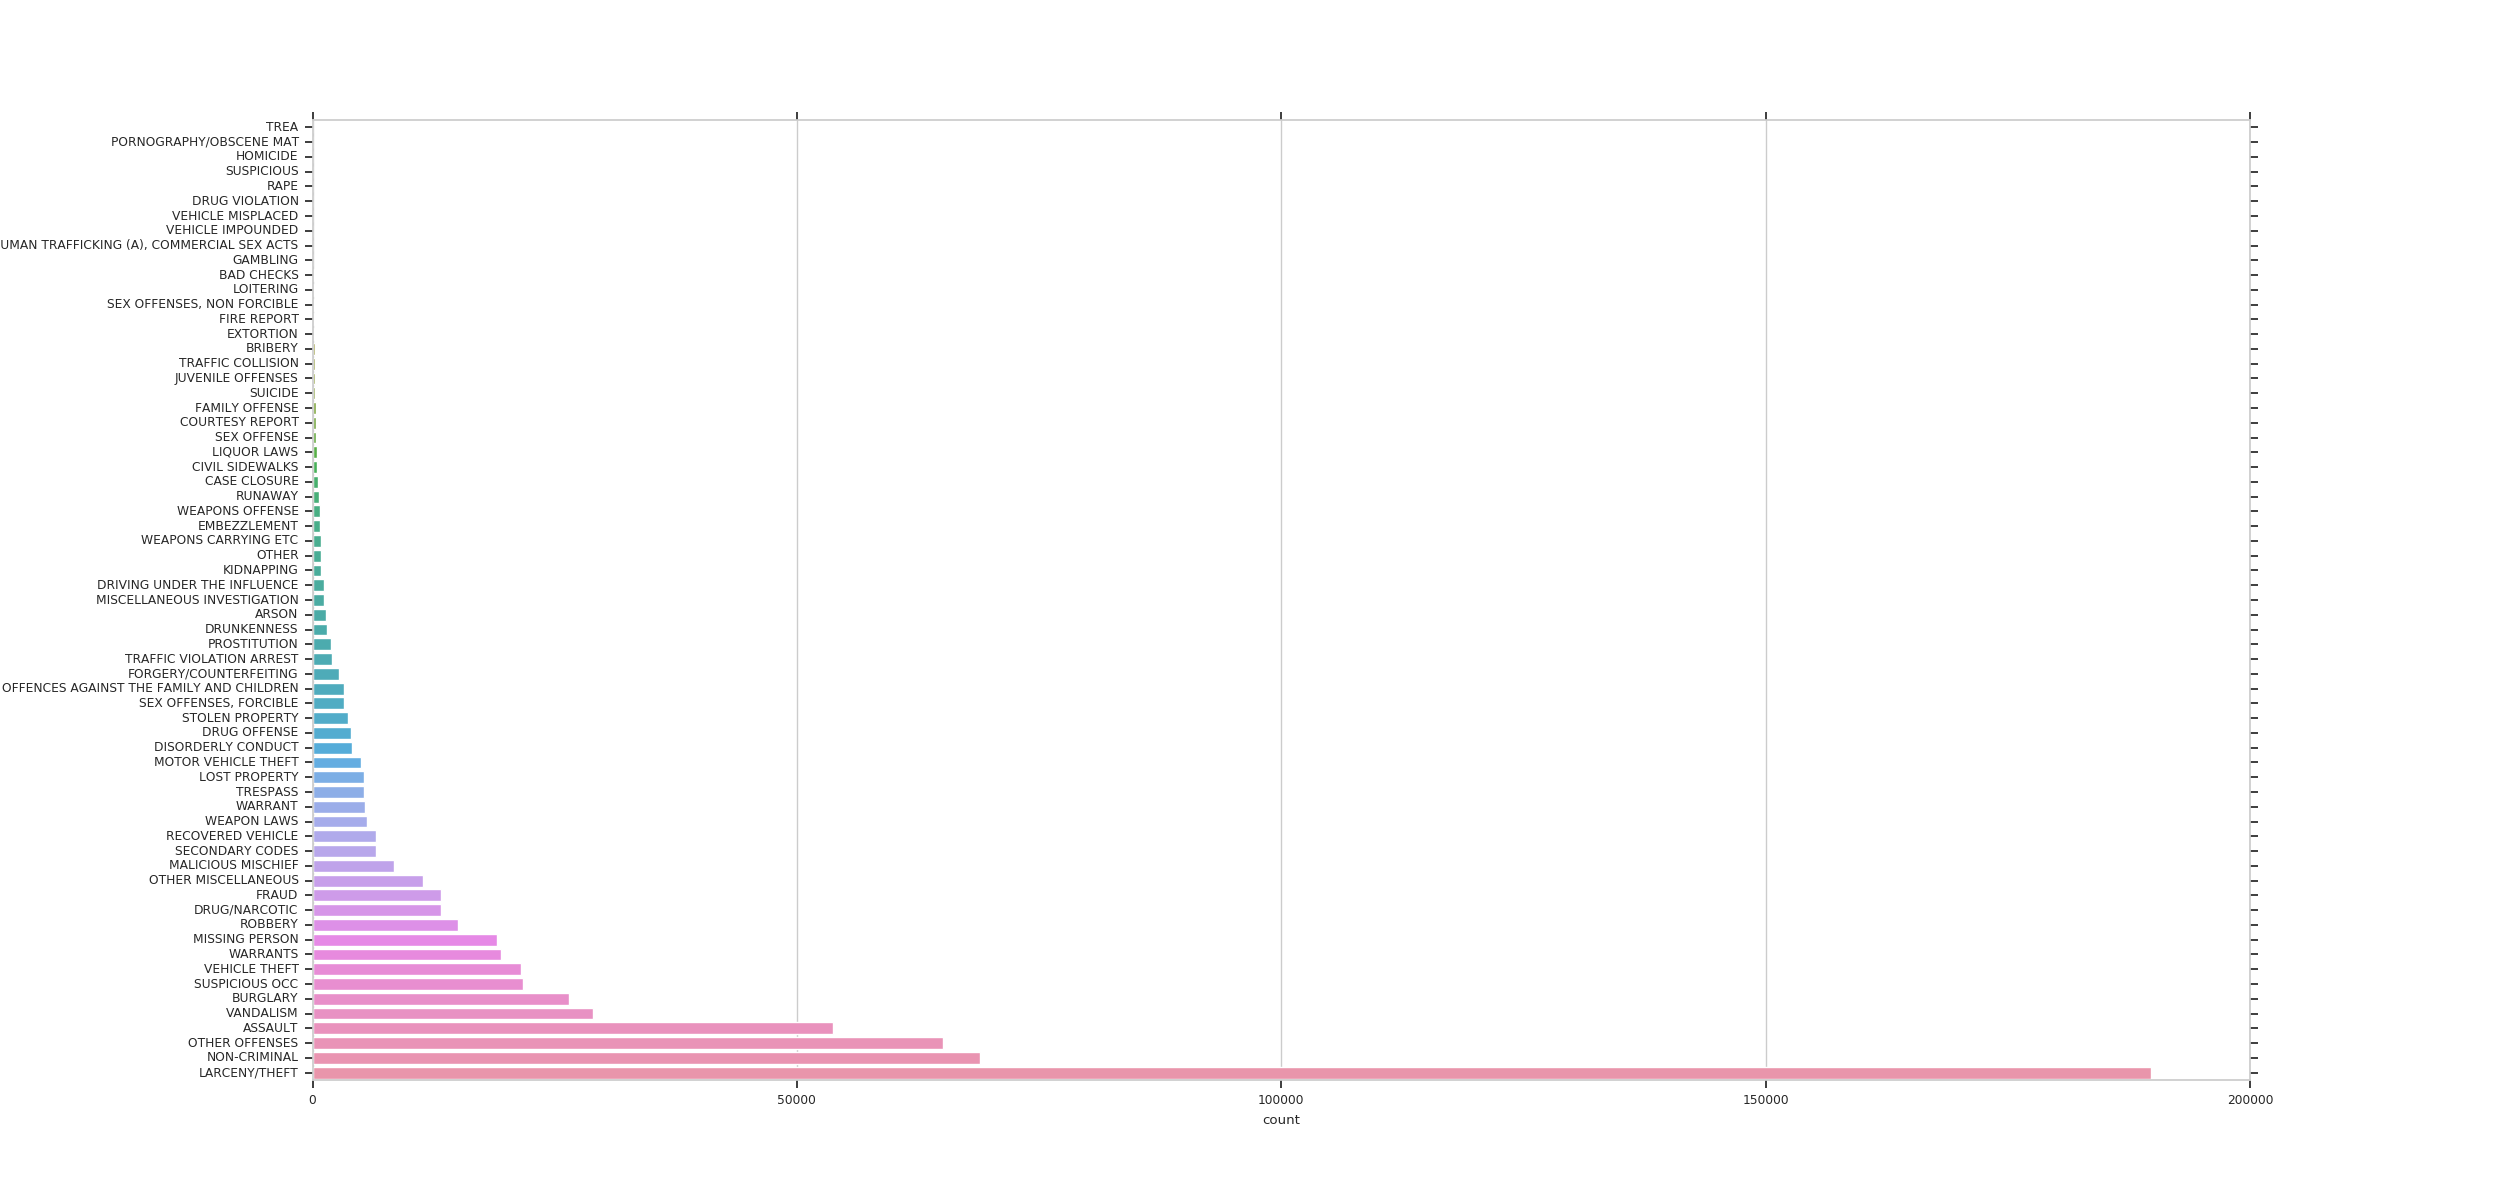

In [17]:
df_X_all = df.groupBy("Category").count().orderBy("count").toPandas()
fig = plt.figure(figsize=(25,12))
sb.set(font_scale=0.8, style = "whitegrid")
sb.barplot(x= "count", y = "Category", data = df_X_all)
plt.legend(loc='upper right')
display(fig)

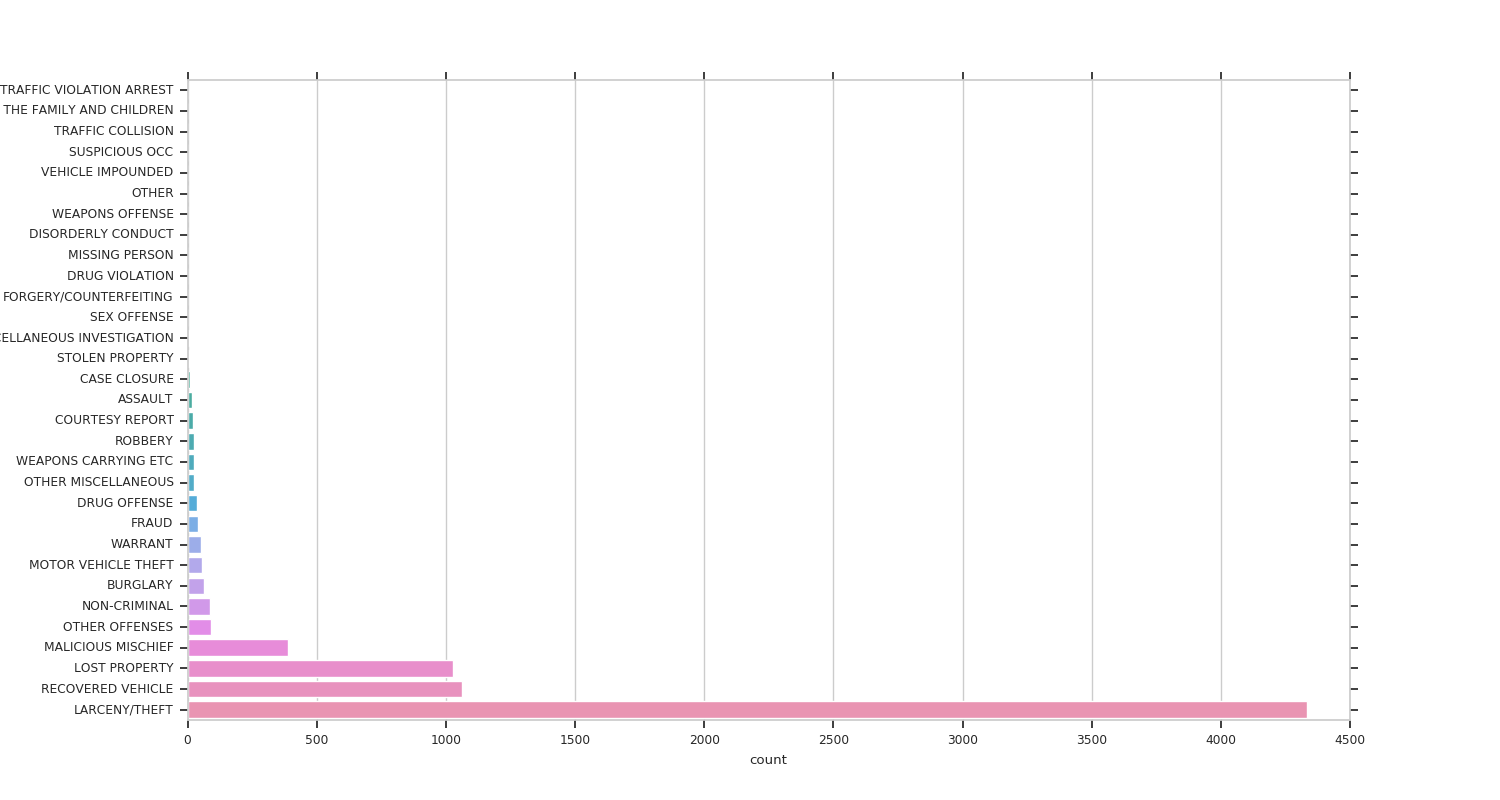

In [18]:
# The original distribution group by each category has similar distribution the null's. Also, it is hard to impute the missing value of cooridinates and hence we delete the whole row if there is any missing value.

df_X_miss = df.where(df["X"].isNull()).groupBy("Category").count().orderBy("count").toPandas()
fig = plt.figure(figsize=(15,8))
sb.set(font_scale=0.8, style = "whitegrid")
sb.barplot(x= "count", y = "Category", data = df_X_miss)
plt.legend(loc='upper right')
display(fig)

In [19]:
df = df.na.drop(how = "any")

In [20]:
df.count()
df.createTempView("sf_crime")

#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [22]:
#Spark SQL based
crime_cat = spark.sql("SELECT category, COUNT(IncidntNum) AS Numbers_Crime \
                       FROM sf_crime \
                       GROUP BY category \
                       ORDER BY Numbers_Crime DESC")
display(crime_cat)
crime_cat = crime_cat.toPandas()

category,Numbers_Crime
LARCENY/THEFT,185413
NON-CRIMINAL,68830
OTHER OFFENSES,64945
ASSAULT,53668
VANDALISM,28998
BURGLARY,26386
SUSPICIOUS OCC,21731
VEHICLE THEFT,21572
WARRANTS,19427
MISSING PERSON,19047


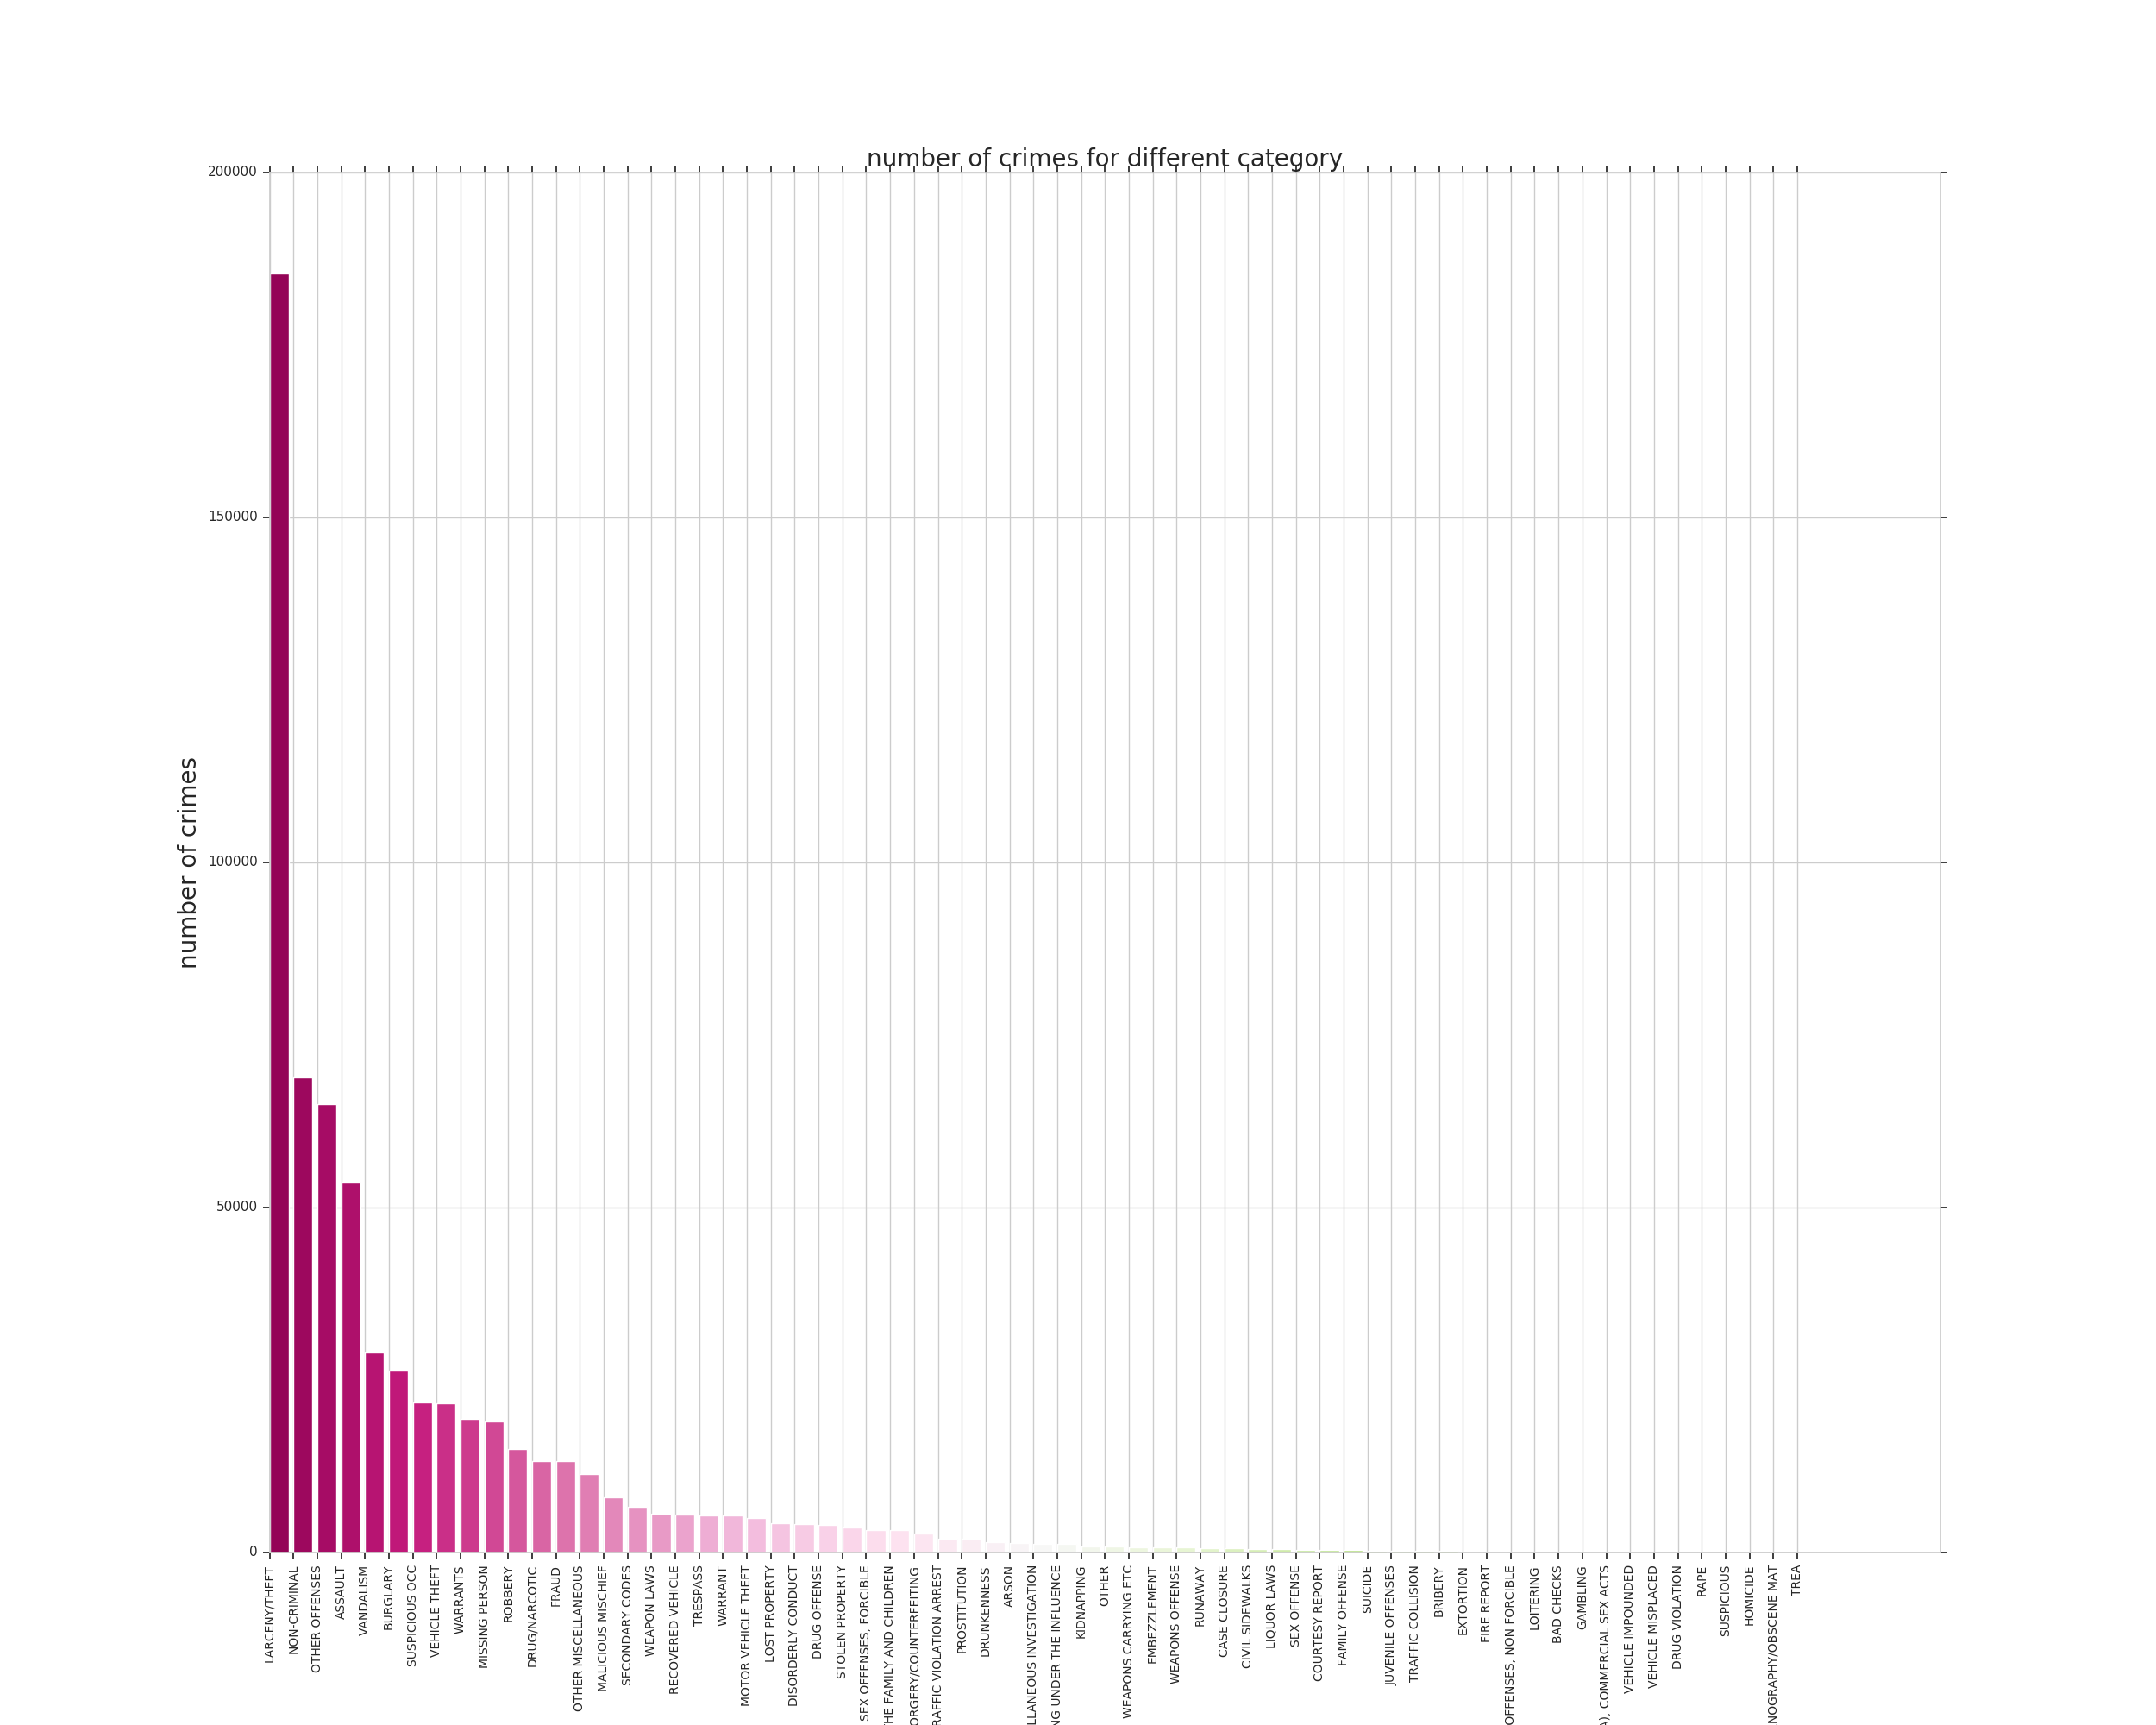

In [23]:
sb.set(style = "whitegrid")
fig = plt.figure(figsize=(25,20))
x = np.arange(len(crime_cat["category"]))
plt.bar(x, crime_cat["Numbers_Crime"], color = sb.color_palette("PiYG", len(x)), data = crime_cat)
plt.ylabel("number of crimes", fontsize=20)
plt.xticks(x, tuple(crime_cat["category"]), fontsize = 10, rotation = 90)
plt.title('number of crimes for different category', fontsize=20)
display(fig)

#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [25]:
df_district = spark.sql("SELECT PdDistrict, COUNT(*) as Numbers_Crime \
                         FROM sf_crime \
                         GROUP BY PdDistrict \
                         ORDER BY Numbers_Crime DESC")
display(df_district)
df_district = df_district.toPandas()

PdDistrict,Numbers_Crime
SOUTHERN,113719
MISSION,86244
NORTHERN,85132
CENTRAL,83503
BAYVIEW,58667
INGLESIDE,50622
TARAVAL,49020
TENDERLOIN,46881
RICHMOND,37318
PARK,35731


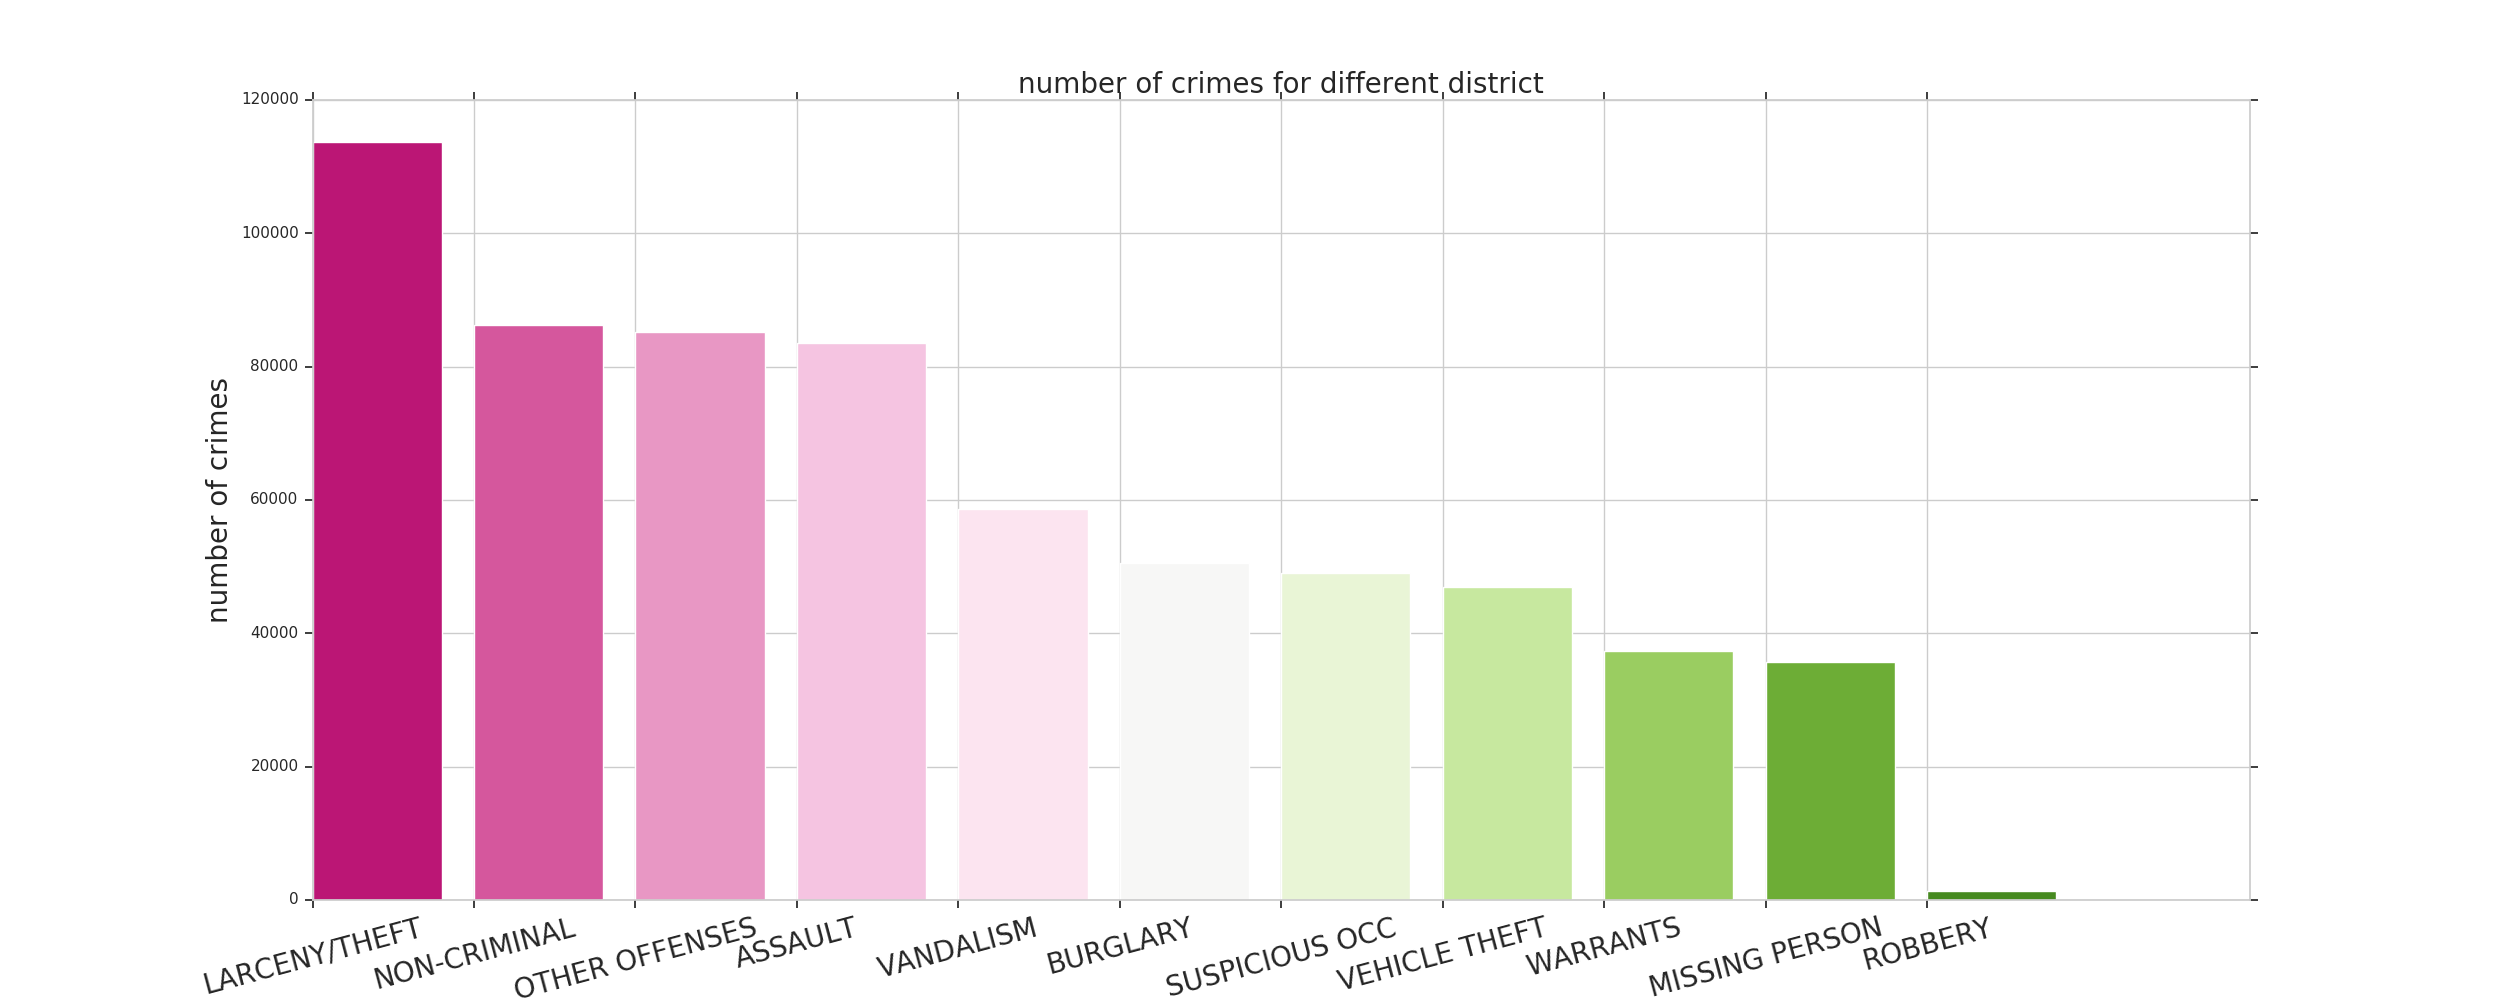

In [26]:
sb.set(style = "whitegrid")
fig = plt.figure(figsize=(25,10))
x = np.arange(len(df_district["PdDistrict"]))
plt.bar(x, df_district["Numbers_Crime"], color = sb.color_palette("PiYG", len(x)), data = df_district)
plt.ylabel("number of crimes", fontsize=20)
plt.xticks(x, tuple(crime_cat["category"]), fontsize = 20, rotation = 15)
plt.title('number of crimes for different district', fontsize=20)
display(fig)

#### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown". 
hints: SF downtown is defiend  via the range of spatial location. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

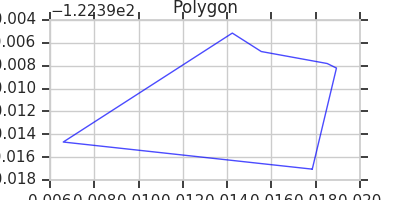

In [28]:
# draw the plot according to the coordinates from Google map to make sure the region of the polygon is correct

from pyspark.sql.types import FloatType, BooleanType
from pyspark.sql.functions import udf
from shapely.geometry import Polygon, Point
poly = Polygon([(37.797844, -122.407050), (37.798937, -122.398205), (37.798519, -122.397808), 
              (37.795541, -122.396759), (37.794233, -122.395145), (37.786599, -122.404677),
              (37.797844, -122.407050)])  # this is when I know the order of the coordinates

x,y = poly.exterior.xy
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.plot(x, y, color='blue', alpha=0.7, linewidth=1)
ax.set_title('Polygon')
display(fig)

In [29]:
# UDF: return true if the crime is in SF downtown area

def in_sf_downtown(x,y):
  point = Point(float(y), float(x))
  return poly.contains(point)


sf_downtown_udf = udf(lambda x, y: in_sf_downtown(x,y), StringType())
#point = (37.792457, -122.404677)
#in_sf_downtown(point)
#print(type(point[0]))

In [30]:
from pyspark.sql.functions import to_timestamp, to_date
df_Q3 = df.select(["IncidntNum", "X", "Y", sf_downtown_udf("X","Y").alias('In_downtown'), to_date("Date_time").alias('Date')])
df_Q3.createOrReplaceTempView("sf_crime_Q3")

In [31]:
df_crime_sunday = spark.sql("SELECT *\
                             FROM sf_crime_Q3 \
                             WHERE WEEKDAY(Date) = 6 and In_downtown = true")
# display(df_crime_sunday)
df_crime_sunday.show(truncate = False)
# df = df_crime_sunday.toPandas()
# df["In_downtown"].value_counts()

+----------+-----------+---------+-----------+----------+
IncidntNum|X |Y |In_downtown|Date |
+----------+-----------+---------+-----------+----------+
150098414 |-122.40683 |37.7969 |true |2015-02-01|
150098414 |-122.40683 |37.7969 |true |2015-02-01|
150098414 |-122.40683 |37.7969 |true |2015-02-01|
150098414 |-122.40683 |37.7969 |true |2015-02-01|
150098492 |-122.40648 |37.795147|true |2015-02-01|
150098492 |-122.40648 |37.795147|true |2015-02-01|
150119195 |-122.40403 |37.79076 |true |2015-02-08|
150119214 |-122.39798 |37.79531 |true |2015-02-08|
150119593 |-122.406494|37.7956 |true |2015-02-08|
150119593 |-122.406494|37.7956 |true |2015-02-08|
150119593 |-122.406494|37.7956 |true |2015-02-08|
150121203 |-122.39937 |37.79323 |true |2015-02-08|
150121203 |-122.39937 |37.79323 |true |2015-02-08|
150139256 |-122.40398 |37.796413|true |2015-02-15|
150140855 |-122.40633 |37.79472 |true |2015-02-15|
150141853 |-122.39642 |37.794144|true |2015-02-15|
150142077 |-122.40507 |37.79801 |true |2015-02-15|
150142760 |-122.40603 |37.79706 |true |2015-02-15|
150153187 |-122.39941 |37.79116 |true |2015-02-01|
150153187 |-122.39941 |37.79116 |true |2015-02-01|
+----------+-----------+---------+-----------+----------+
only showing top 20 rows

#### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [33]:
df_crime_month = spark.sql("SELECT YEAR(Date_time) AS Year, MONTH(Date_time) AS Month, COUNT(*) AS Numbers_Crime\
                            FROM sf_crime\
                            GROUP BY MONTH(Date_time), YEAR(Date_time)\
                            ORDER BY YEAR(Date_time), MONTH(Date_time)")
display(df_crime_month)
df_crime_month = df_crime_month.toPandas()
df_crime_month
# df_crime_month["Year"] = df_crime_month["Year"].astype(str)
# df_crime_month["Month"] = df_crime_month["Month"].astype(str)
# df_crime_month.info()
# pd.pivot_table(data = df_crime_month, values=Numbers_Crime, index=Year, columns=Month, aggfunc='sum')

Year,Month,Numbers_Crime
2015,1,13606
2015,2,12329
2015,3,13929
2015,4,12959
2015,5,13729
2015,6,13304
2015,7,13365
2015,8,13730
2015,9,12896
2015,10,13147


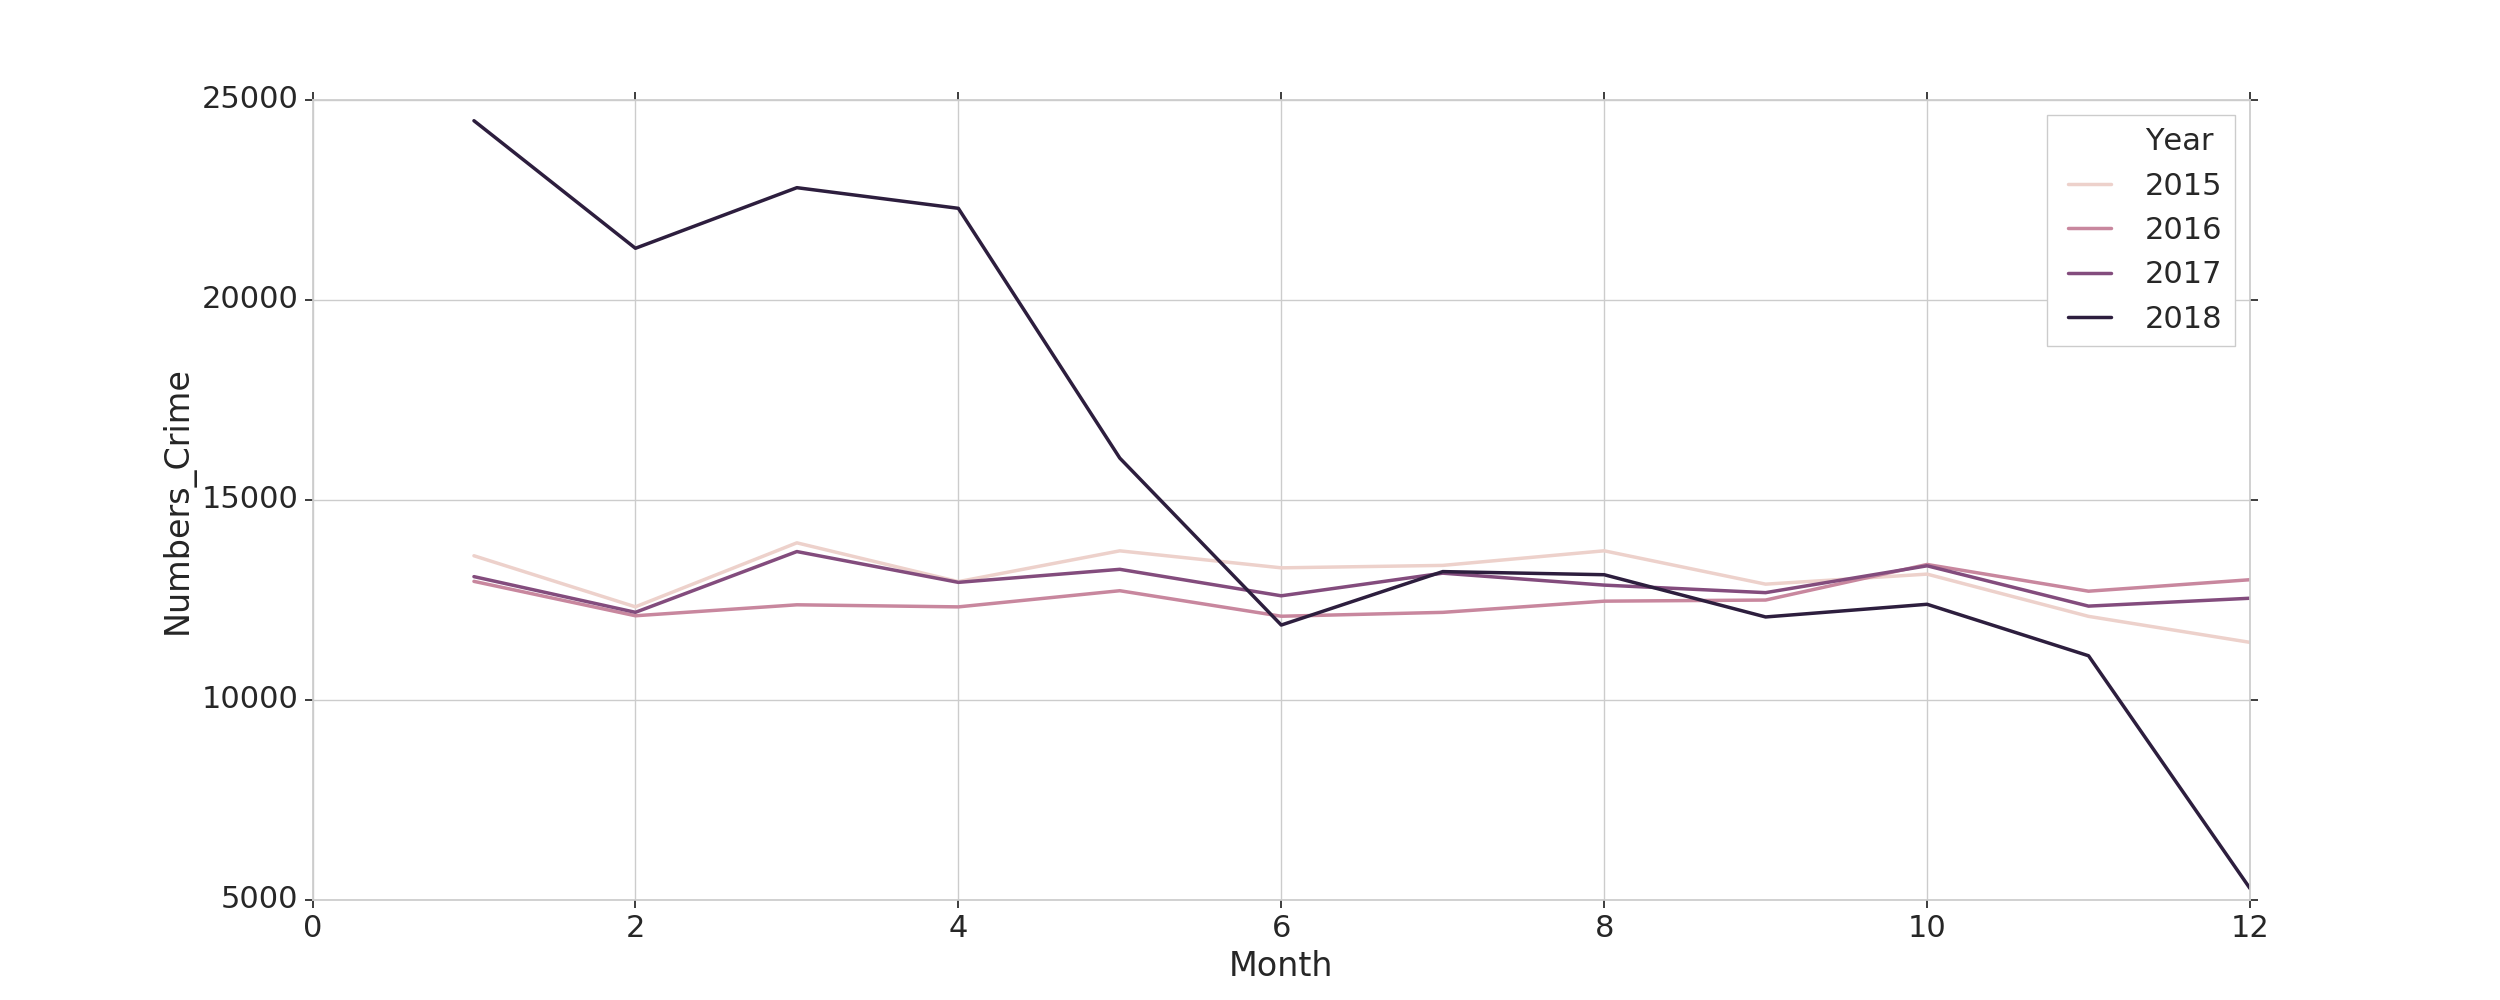

In [34]:
fig = plt.figure(figsize=(25,10))
sb.set(font_scale=2, style = "whitegrid", rc={"lines.linewidth": 2.5})
sb.lineplot(x= "Month", y = "Numbers_Crime", hue="Year", data = df_crime_month)
plt.legend(loc='upper right')
display(fig)

##### What is the business impact for your result?

Except for the first half year of 2018, there is no big difference between the number of crimes bewteen each year. In the year of 2018, the police seemed experimenting some new method because the crime was decreasing overall(exclude demcember due to imcomplete of the data) and the new method seemd to worked. We may invest more on the new method.

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15, 2018/10/15. Then, give your travel suggestion to visit SF.

In [37]:
df_crime_same_date = spark.sql("SELECT YEAR(Date_time) AS Year, DATE(Date_time) AS Date, HOUR(Date_time) AS Hour, COUNT(*) AS Numbers_Crime\
                                FROM sf_crime\
                                WHERE DATE(Date_time) in ('2015-12-15','2016-12-15', '2017-12-15', '2018-10-15')\
                                GROUP BY HOUR(Date_time), DATE(Date_time), YEAR(Date_time)\
                                ORDER BY YEAR(Date_time), DATE(Date_time), HOUR(Date_time)")

display(df_crime_same_date)
df_crime_same_date = df_crime_same_date.toPandas()
df_crime_same_date

Year,Date,Hour,Numbers_Crime
2015,2015-12-15,0,15
2015,2015-12-15,1,6
2015,2015-12-15,2,5
2015,2015-12-15,3,4
2015,2015-12-15,4,10
2015,2015-12-15,5,3
2015,2015-12-15,6,4
2015,2015-12-15,7,8
2015,2015-12-15,8,12
2015,2015-12-15,9,10


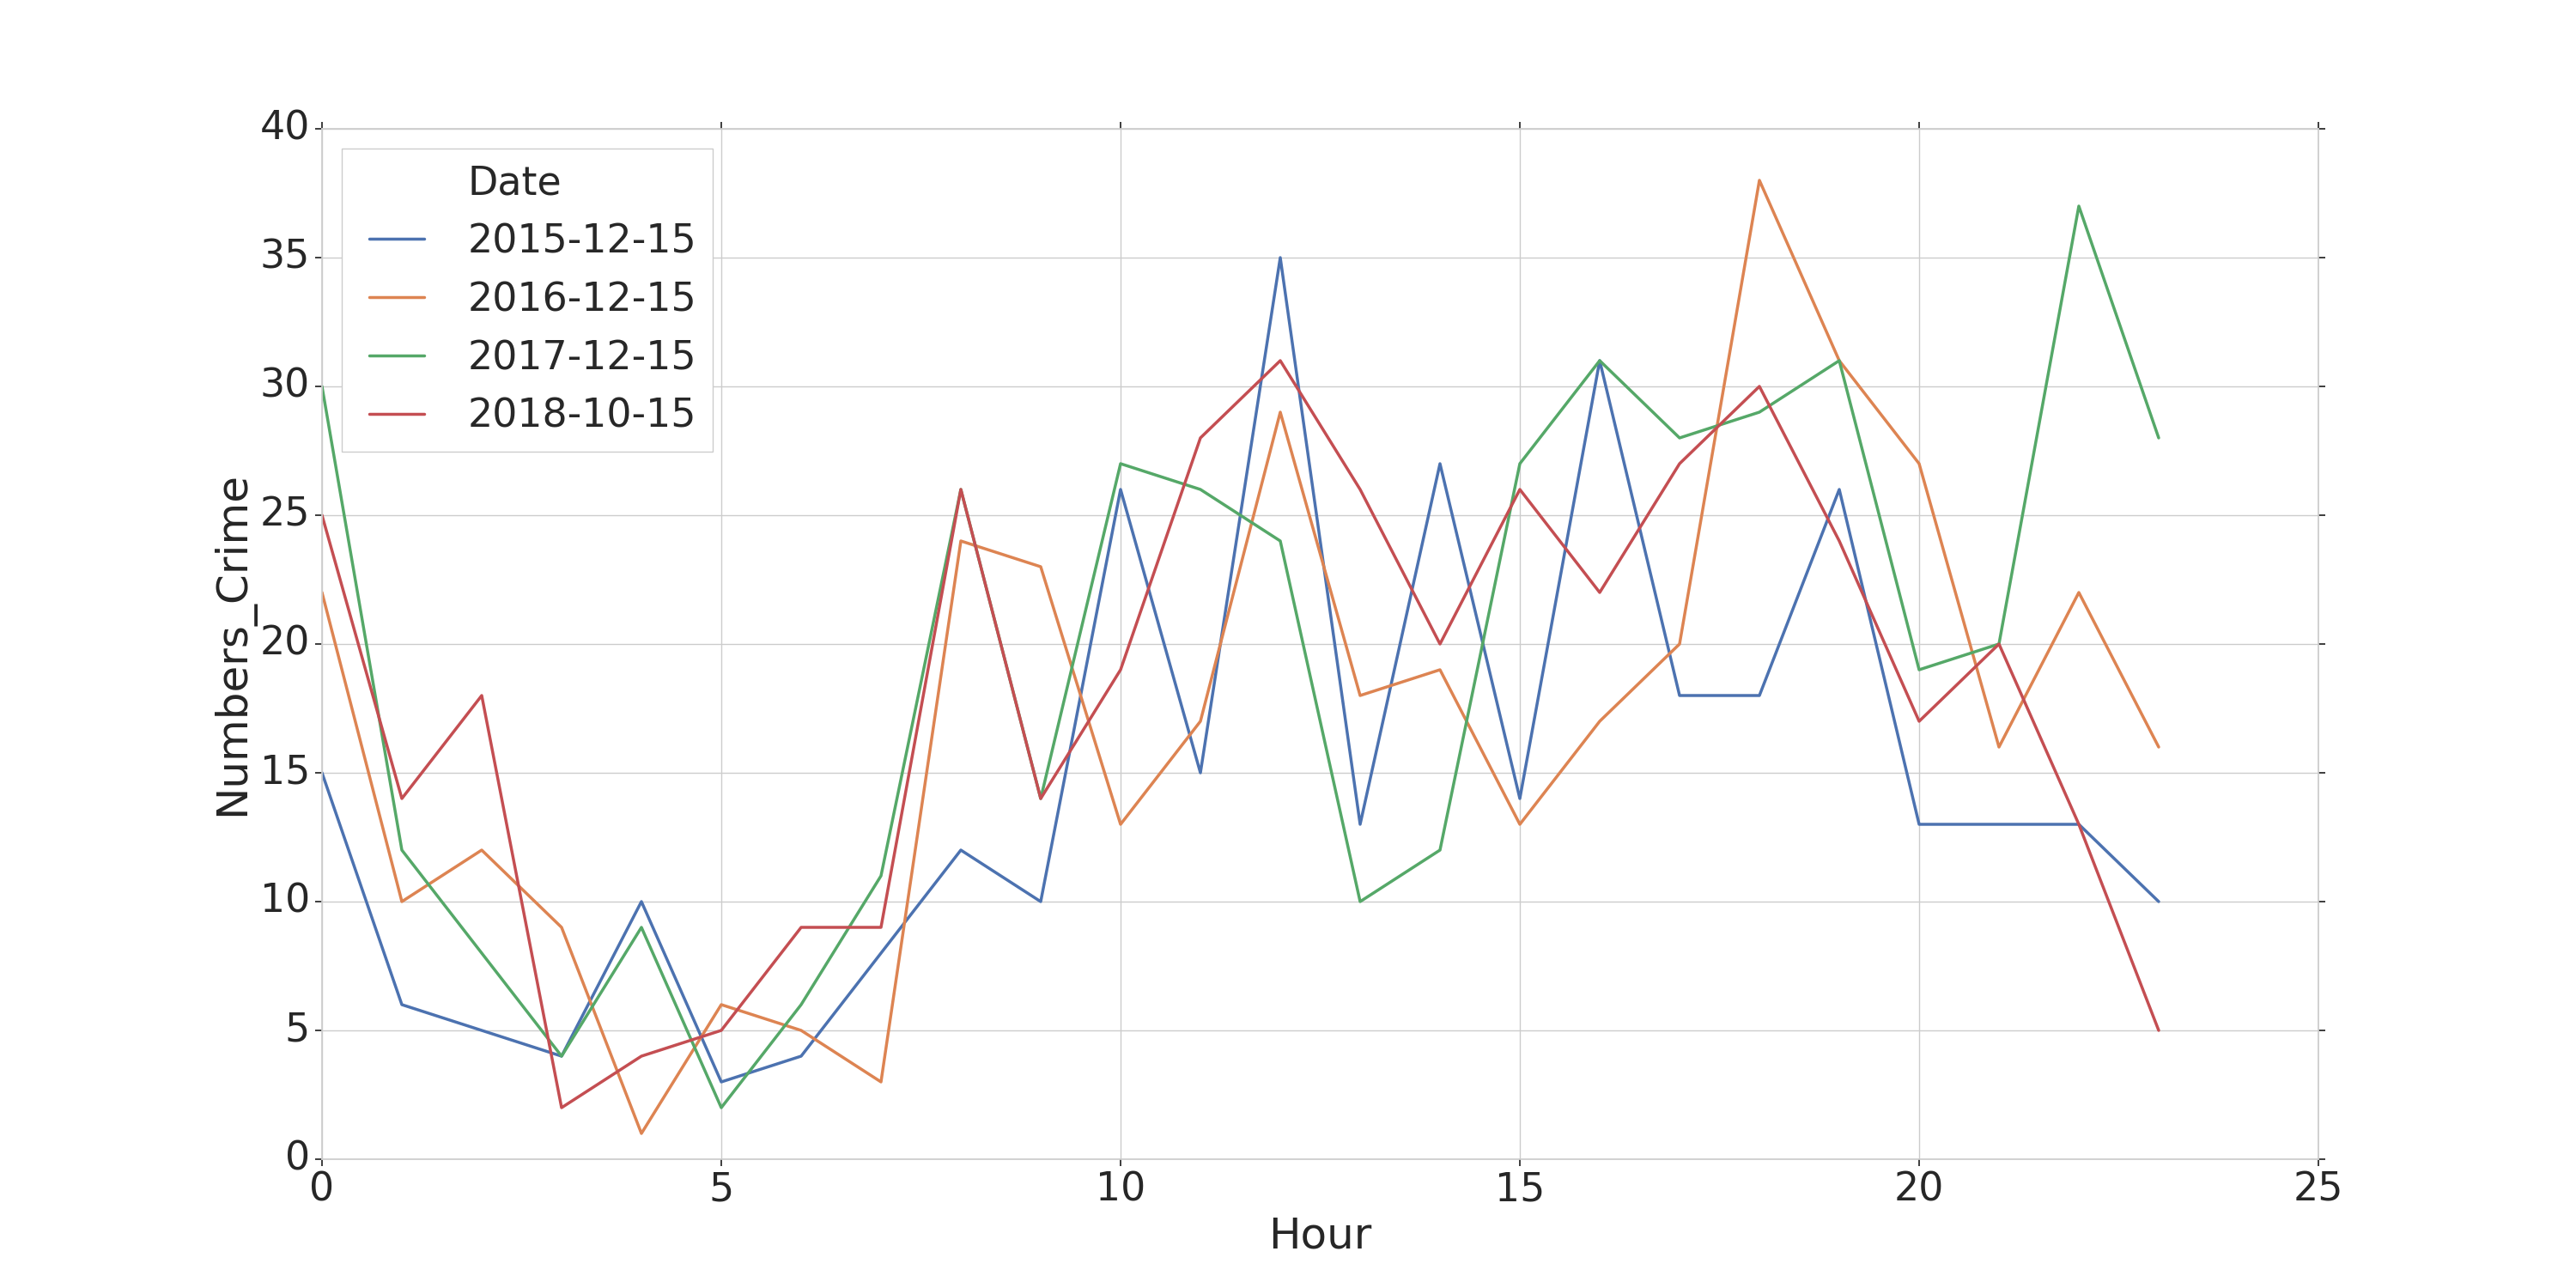

In [38]:
fig = plt.figure(figsize=(30,15))
sb.set(font_scale=3, style = "whitegrid", rc={"lines.linewidth": 2.5})
sb.lineplot(x= "Hour", y = "Numbers_Crime", hue="Date", data = df_crime_same_date)
plt.legend(loc='upper left')
display(fig)

##### give your travel suggestion to visit SF

Visitors should pay more attention after 8 a.m. because the number of crimes surge up after that time and decrease again after 1 a.m.. Also, visitors should be extremely careful during lunch time and dinner time because it is having highest number of crimes during theses two periods.

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [41]:
df_crime_danger_dist = spark.sql("SELECT PdDistrict, COUNT(*) AS Numbers_Crime \
                                  FROM sf_crime \
                                  GROUP BY PdDistrict \
                                  ORDER BY Numbers_Crime DESC \
                                  LIMIT 3")

display(df_crime_danger_dist)

PdDistrict,Numbers_Crime
SOUTHERN,113719
MISSION,86244
NORTHERN,85132


In [42]:
df_crime_danger_cat = spark.sql("SELECT \
                                    Category, \
                                    HOUR(Date_time) AS Hour, \
                                    COUNT(*) AS Numbers_Crime \
                                 FROM sf_crime \
                                 WHERE PdDistrict IN ('SOUTHERN','MISSION','NORTHERN') \
                                 GROUP BY Category, HOUR(Date_time) \
                                 ORDER BY HOUR(Date_time), Numbers_Crime DESC")

display(df_crime_danger_cat)
df_crime_danger_cat = df_crime_danger_cat.toPandas()
df_crime_danger_cat.head(5)
# pd.pivot_table(df_crime_danger_cat, values='Numbers_Crime', index=['Hour'], columns=['Category'], aggfunc=np.sum)

Category,Hour,Numbers_Crime
LARCENY/THEFT,0,3714
OTHER OFFENSES,0,1941
NON-CRIMINAL,0,1224
ASSAULT,0,1152
FRAUD,0,669
VANDALISM,0,570
SUSPICIOUS OCC,0,552
BURGLARY,0,550
WARRANTS,0,390
ROBBERY,0,357


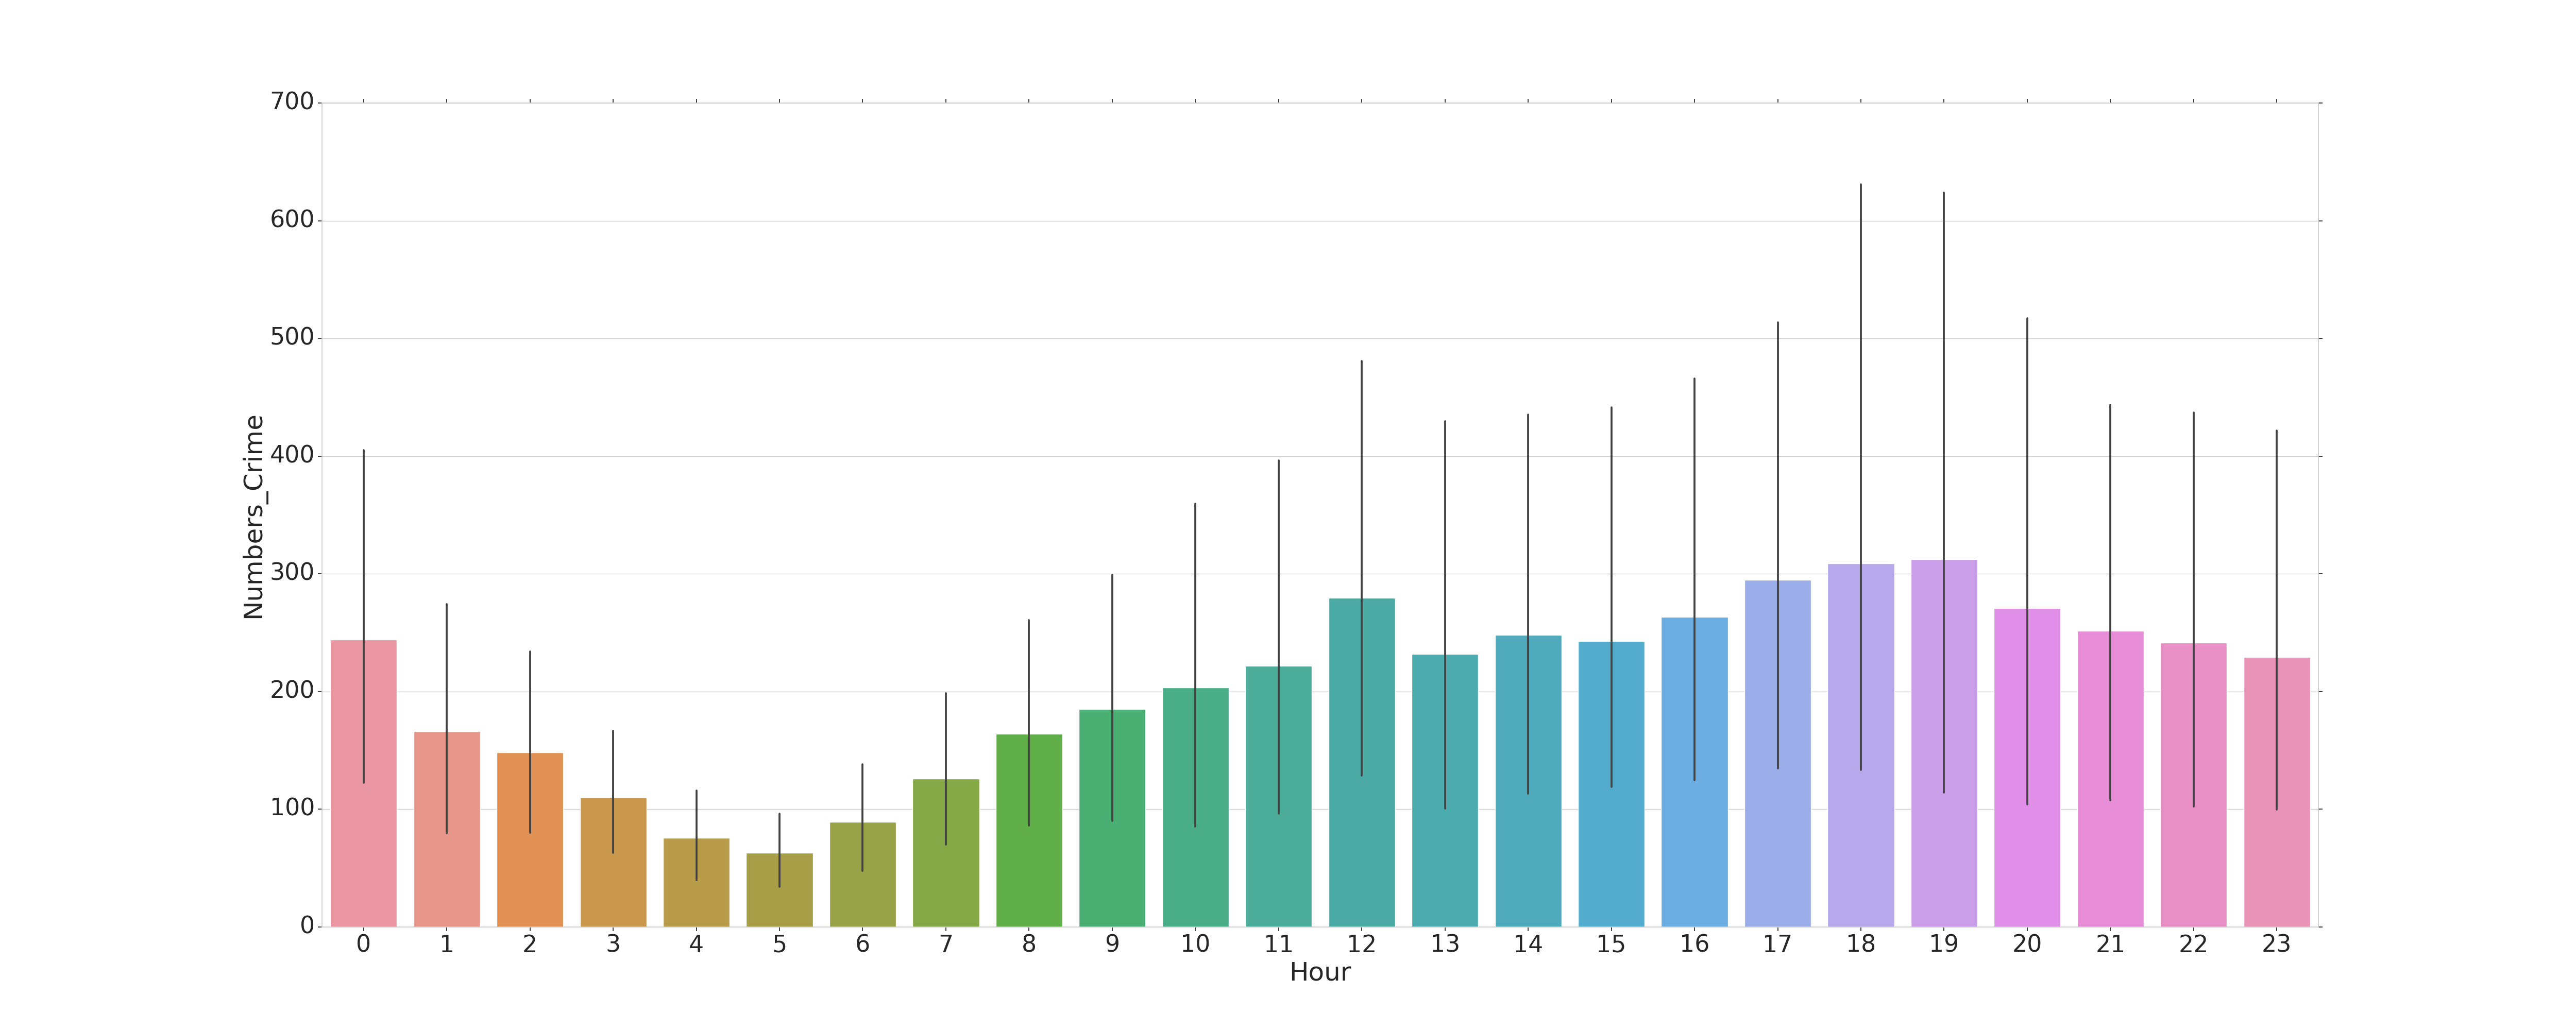

In [43]:
fig = plt.figure(figsize=(50,20))
sb.set(font_scale=3, style = "whitegrid")
sb.barplot(x= "Hour", y = "Numbers_Crime",  data = df_crime_danger_cat)
plt.legend(loc='upper left')
display(fig)

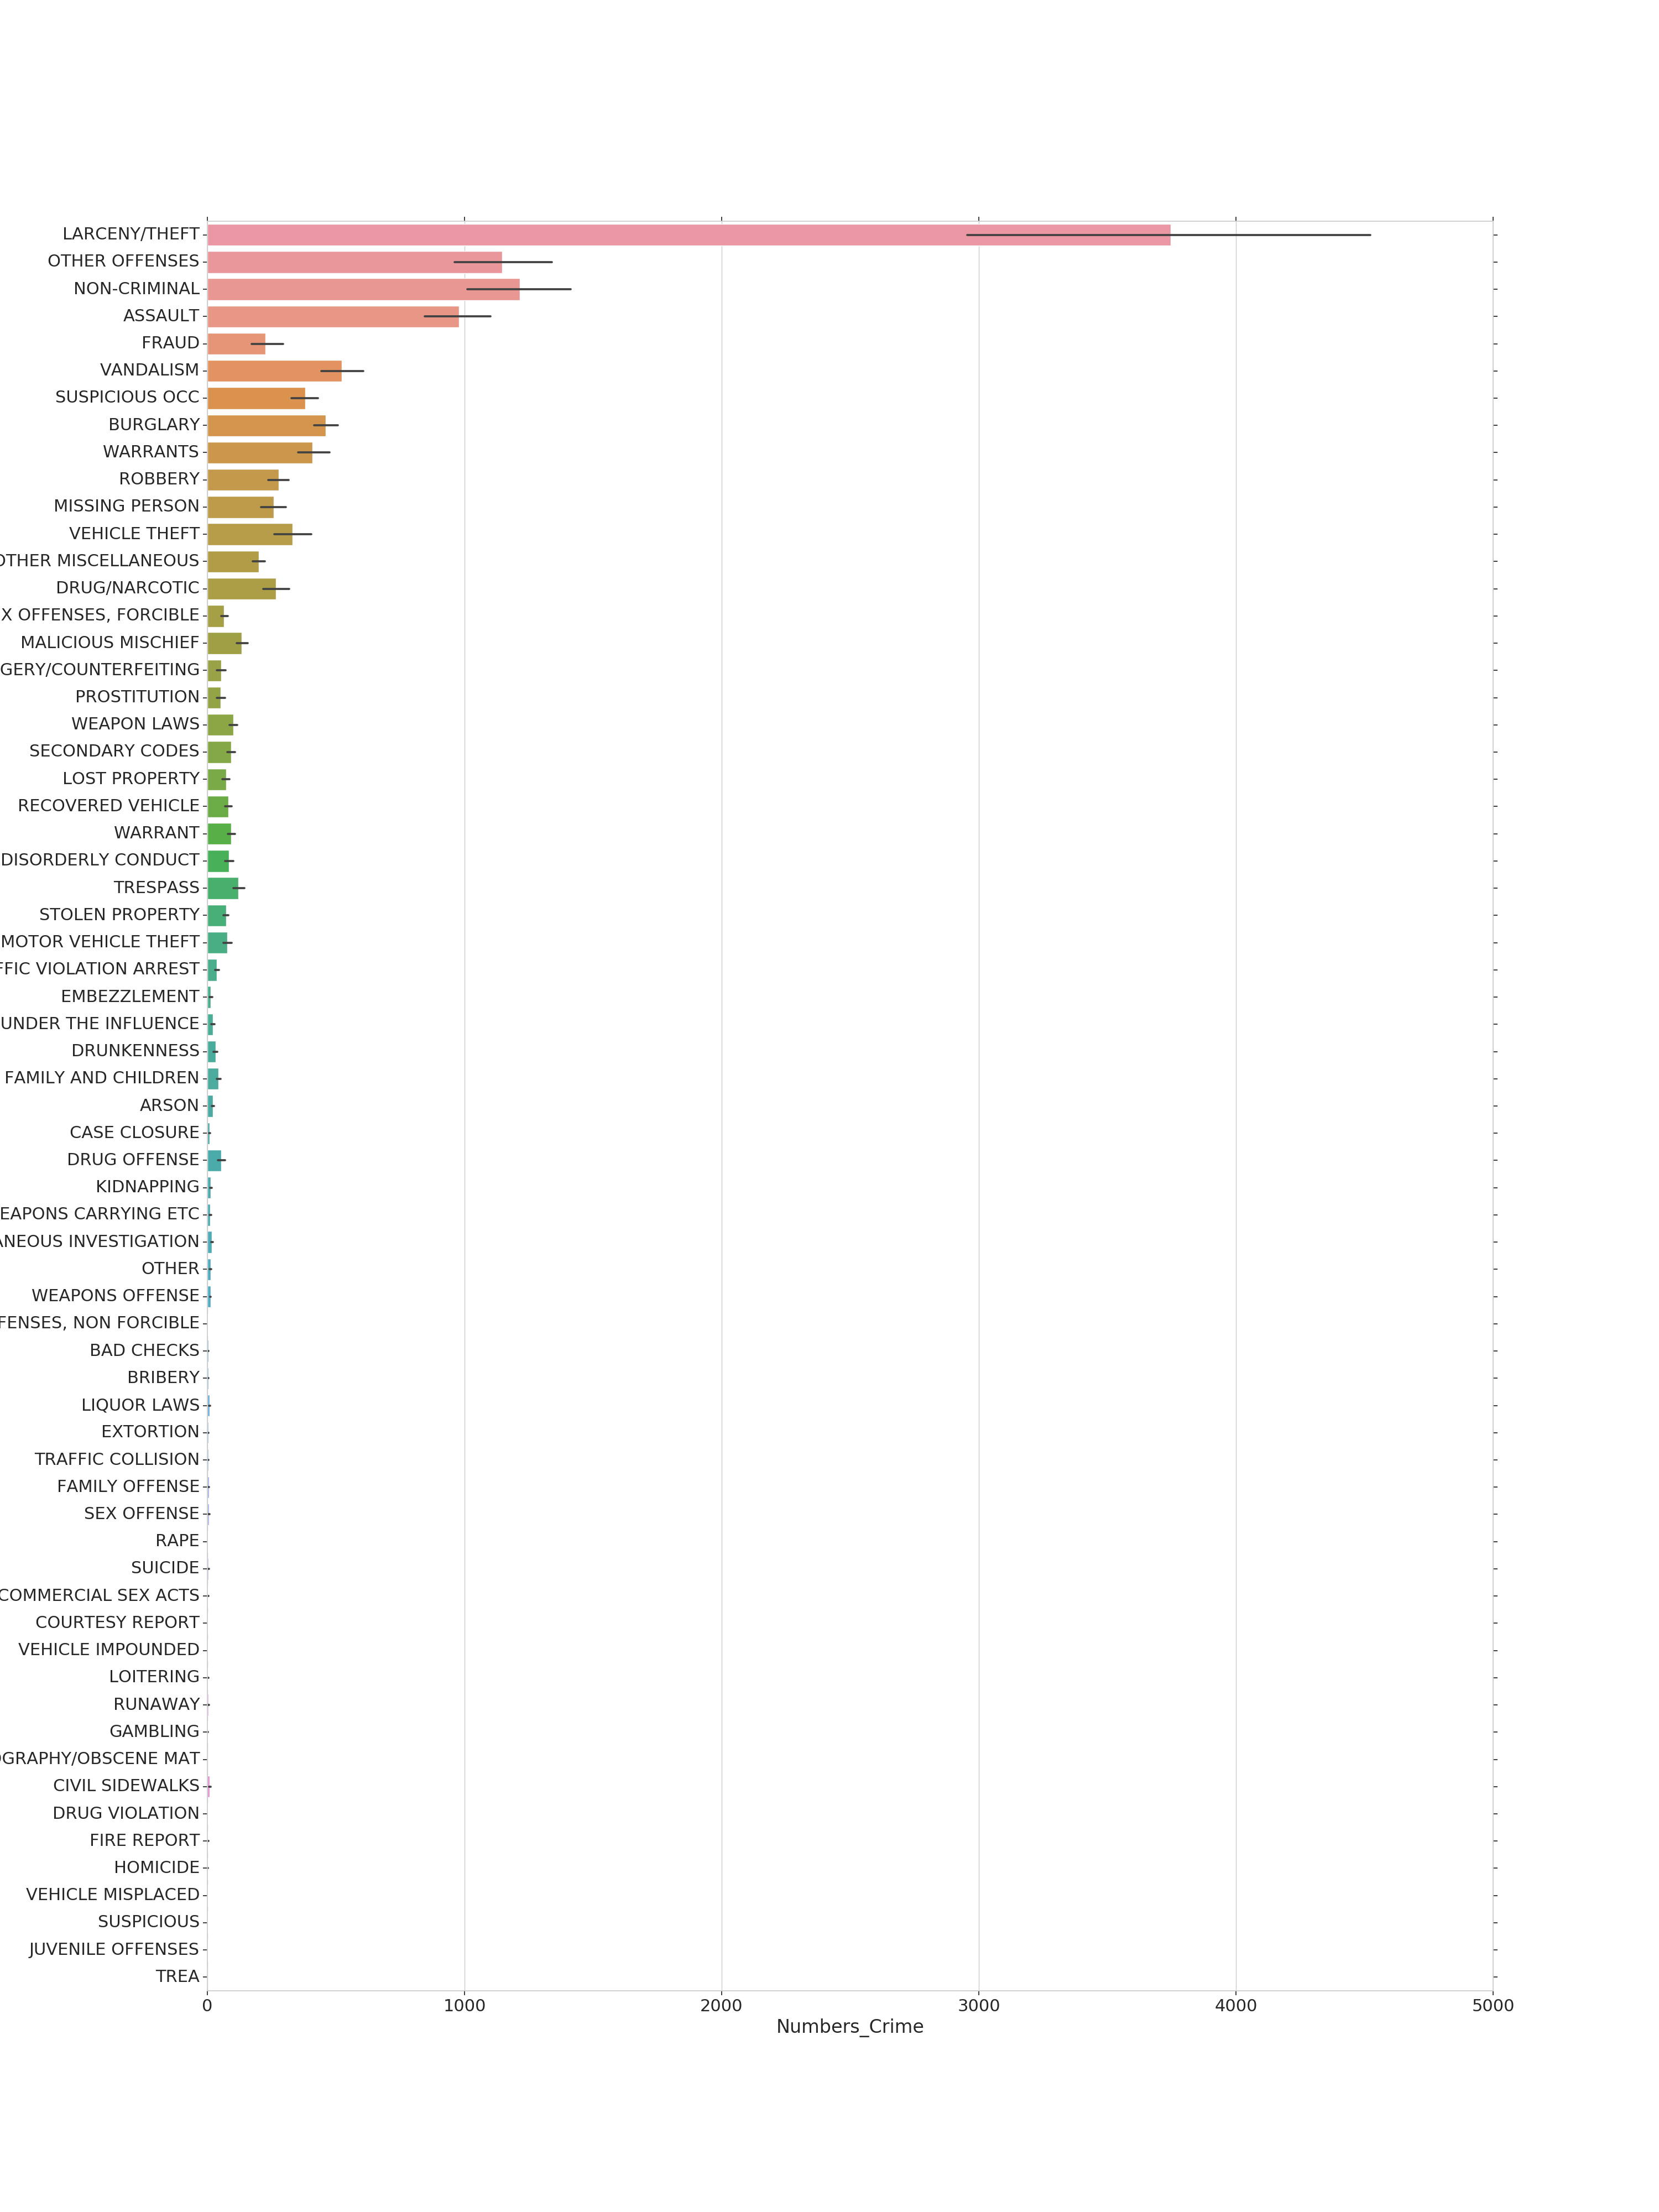

In [44]:
fig = plt.figure(figsize=(30,40))
sb.set(font_scale=2, style = "whitegrid")
sb.barplot(x= "Numbers_Crime", y = "Category", data = df_crime_danger_cat)
plt.legend(loc='upper left')
plt.xticks(rotation = 0)
display(fig)

##### give your advice to distribute the police based on your analysis results

We should enhance more police resources after 8 a.m. because the number of crimes surge up after that time and decrease again after 1 a.m.. Also, police resources should be in the maximun during lunch time and dinner time because it is having highest number of crimes during theses two periods and "THEFTS" and "OTHER OFFENSE" is the most frequent crime during these three district. The police resources should be configured according to of the "THEFTS" and "OTHER OFFENSE" more.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resulition. Based on the output, give your hints to adjust the policy.

In [47]:
df_crime_percent_cat = spark.sql("SELECT Category, COUNT(*) AS Numbers_Crime \
                                  FROM sf_crime \
                                  GROUP BY Category")


df_crime_percent_cat_new = df_crime_percent_cat.toPandas()
sum_crime = df_crime_percent_cat_new["Numbers_Crime"].sum()
df_crime_percent_cat_new = df_crime_percent_cat_new.sort_values(by = ["Numbers_Crime"], ascending = False)
df_crime_percent_cat_new["Crime_Percent"] = df_crime_percent_cat_new["Numbers_Crime"].map(lambda x: str(round((float(x)/sum_crime)*100,2))+" %")
df_crime_percent_cat_new.drop(["Numbers_Crime"], axis = 1)

Out[ 34 ]: 
 Category Crime_Percent
58 LARCENY/THEFT 28.6 %
55 NON-CRIMINAL 10.62 %
8 OTHER OFFENSES 10.02 %
20 ASSAULT 8.28 %
49 VANDALISM 4.47 %
60 BURGLARY 4.07 %
33 SUSPICIOUS OCC 3.35 %
56 VEHICLE THEFT 3.33 %
12 WARRANTS 3.0 %
6 MISSING PERSON 2.94 %
34 ROBBERY 2.31 %
50 DRUG/NARCOTIC 2.05 %
0 FRAUD 2.04 %
2 OTHER MISCELLANEOUS 1.76 %
40 MALICIOUS MISCHIEF 1.24 %
4 SECONDARY CODES 1.01 %
29 WEAPON LAWS 0.87 %
48 RECOVERED VEHICLE 0.84 %
54 TRESPASS 0.82 %
15 WARRANT 0.82 %
23 MOTOR VEHICLE THEFT 0.77 %
21 LOST PROPERTY 0.66 %
46 DISORDERLY CONDUCT 0.64 %
10 DRUG OFFENSE 0.61 %
57 STOLEN PROPERTY 0.57 %
36 SEX OFFENSES, FORCIBLE 0.5 %
24 OFFENCES AGAINST THE FAMILY AND CHILDREN 0.5 %
14 FORGERY/COUNTERFEITING 0.42 %
19 TRAFFIC VIOLATION ARREST 0.31 %
41 PROSTITUTION 0.3 %
.. ... ...
39 OTHER 0.13 %
63 WEAPONS CARRYING ETC 0.12 %
42 EMBEZZLEMENT 0.12 %
43 WEAPONS OFFENSE 0.11 %
47 RUNAWAY 0.1 %
62 CASE CLOSURE 0.09 %
5 CIVIL SIDEWALKS 0.08 %
3 LIQUOR LAWS 0.07 %
53 SEX OFFENSE 0.06 %
37 COURTESY REPORT 0.06 %
52 FAMILY OFFENSE 0.06 %
1 SUICIDE 0.05 %
30 JUVENILE OFFENSES 0.04 %
25 TRAFFIC COLLISION 0.04 %
18 BRIBERY 0.03 %
26 EXTORTION 0.03 %
11 FIRE REPORT 0.02 %
64 SEX OFFENSES, NON FORCIBLE 0.02 %
31 LOITERING 0.02 %
45 BAD CHECKS 0.02 %
16 GAMBLING 0.01 %
17 HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS 0.01 %
38 VEHICLE IMPOUNDED 0.01 %
27 VEHICLE MISPLACED 0.01 %
7 DRUG VIOLATION 0.01 %
44 RAPE 0.01 %
61 SUSPICIOUS 0.0 %
35 HOMICIDE 0.0 %
51 PORNOGRAPHY/OBSCENE MAT 0.0 %
28 TREA 0.0 %

[65 rows x 2 columns]

##### give your advice to distribute the police based on your analysis results

The police resources should be configured according to of the "THEFTS", "OTHER OFFENSE", and "ASSAULT" more. Also, there should be a penalty or other policy of "NON-CRIMINAL" so that to decrease the percentage of "NON-CRIMINAL" and waste the government resources.

#### Q8 question (Apply Spark ML clustering for spatial data analysis)
Extra: visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)  
You can refer Spark ML Kmeans a example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [50]:
assembled.show(truncate = False)

+-----------+---------+----------------------------------------+---------------------------------------+
X |Y |features |scaledFeatures |
+-----------+---------+----------------------------------------+---------------------------------------+
-122.421585|37.7617 |[-122.42158508300781,37.76169967651367] |[-4672.556103570993,1586.069856033148] |
-122.414406|37.78419 |[-122.4144058227539,37.7841911315918] |[-4672.2820873809915,1587.014543884154]|
-122.414406|37.78419 |[-122.4144058227539,37.7841911315918] |[-4672.2820873809915,1587.014543884154]|
-122.414406|37.78419 |[-122.4144058227539,37.7841911315918] |[-4672.2820873809915,1587.014543884154]|
-122.43112 |37.80047 |[-122.43112182617188,37.80046844482422] |[-4672.920099572591,1587.6982248645206]|
-122.45178 |37.787086|[-122.4517822265625,37.787086486816406] |[-4673.708660510451,1587.1361548201976]|
-122.374016|37.729202|[-122.37401580810547,37.72920227050781] |[-4670.740491515026,1584.7048974505972]|
-122.374016|37.729202|[-122.37401580810547,37.72920227050781] |[-4670.740491515026,1584.7048974505972]|
-122.40657 |37.787807|[-122.40657043457031,37.78780746459961] |[-4671.983028266079,1587.1664373852993]|
-122.4173 |37.78626 |[-122.41729736328125,37.786258697509766]|[-4672.392450968676,1587.1013859491547]|
-122.41335 |37.769073|[-122.4133529663086,37.769073486328125] |[-4672.241902222415,1586.3795713682896]|
-122.41335 |37.769073|[-122.4133529663086,37.769073486328125] |[-4672.241902222415,1586.3795713682896]|
-122.41335 |37.769073|[-122.4133529663086,37.769073486328125] |[-4672.241902222415,1586.3795713682896]|
-122.41335 |37.769073|[-122.4133529663086,37.769073486328125] |[-4672.241902222415,1586.3795713682896]|
-122.4322 |37.76511 |[-122.43219757080078,37.76511001586914] |[-4672.961158321571,1586.2130973728358]|
-122.42228 |37.781754|[-122.42227935791016,37.78175354003906] |[-4672.58260247991,1586.9121599735718] |
-122.42228 |37.781754|[-122.42227935791016,37.78175354003906] |[-4672.58260247991,1586.9121599735718] |
-122.38794 |37.74226 |[-122.387939453125,37.74225997924805] |[-4671.271925677358,1585.253348351885] |
-122.45864 |37.7672 |[-122.4586410522461,37.7672004699707] |[-4673.970446434801,1586.3009007891098]|
-122.38978 |37.735226|[-122.38977813720703,37.735225677490234]|[-4671.342104106467,1584.9578930606274]|
+-----------+---------+----------------------------------------+---------------------------------------+
only showing top 20 rows

In [51]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

df_kmeans = spark.sql("SELECT X, Y FROM sf_crime")
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol="features")
assembled = assembler.transform(df_kmeans)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled)
assembled = scaler_model.transform(assembled)

In [52]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(assembled.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(assembled) # requires Spark 2.0 or later

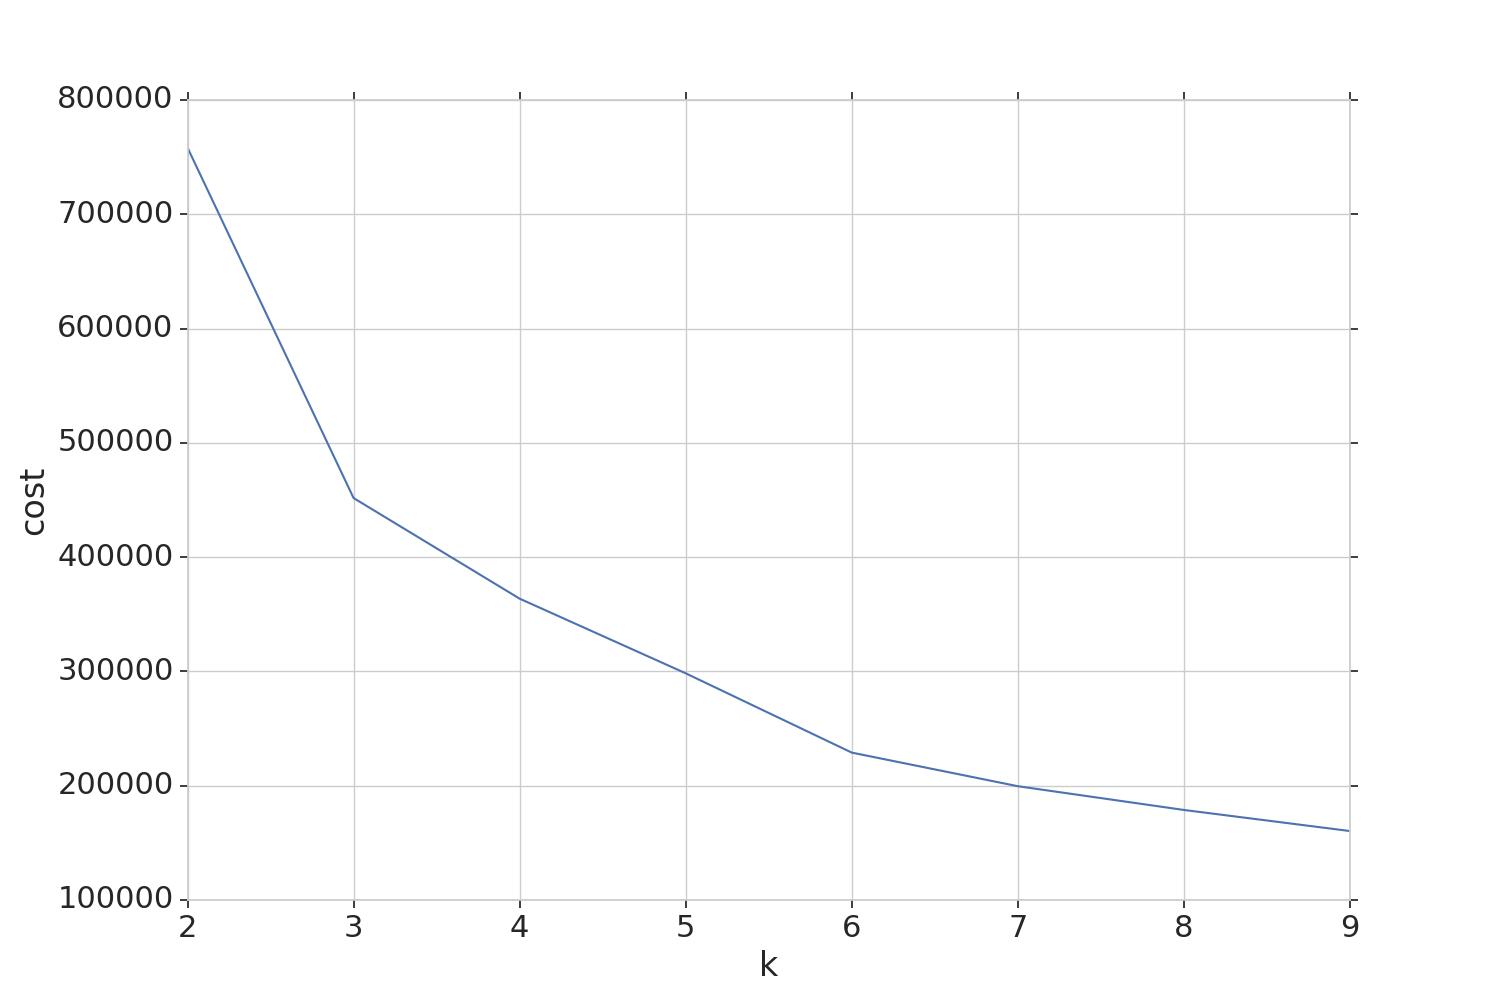

In [53]:
# according to the cost versus number of clusters, I chose k = 6
fig, ax = plt.subplots(1,1, figsize =(15,10))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
display(fig)

In [54]:
# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(assembled)

# Make predictions
predictions = model.transform(assembled)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5531369254008568
Cluster Centers: 
[-122.4209888 37.7607022]
[-122.40690896 37.78534447]
[-122.45262653 37.72421385]
[-122.39789637 37.73246614]
[-122.48087173 37.7648169 ]
[-122.43185913 37.78716638]

In [55]:
predictions.select("X","Y","prediction").show(truncate = False)

+-----------+---------+----------+
X |Y |prediction|
+-----------+---------+----------+
-122.421585|37.7617 |0 |
-122.414406|37.78419 |1 |
-122.414406|37.78419 |1 |
-122.414406|37.78419 |1 |
-122.43112 |37.80047 |5 |
-122.45178 |37.787086|5 |
-122.374016|37.729202|3 |
-122.374016|37.729202|3 |
-122.40657 |37.787807|1 |
-122.4173 |37.78626 |1 |
-122.41335 |37.769073|0 |
-122.41335 |37.769073|0 |
-122.41335 |37.769073|0 |
-122.41335 |37.769073|0 |
-122.4322 |37.76511 |0 |
-122.42228 |37.781754|5 |
-122.42228 |37.781754|5 |
-122.38794 |37.74226 |3 |
-122.45864 |37.7672 |4 |
-122.38978 |37.735226|3 |
+-----------+---------+----------+
only showing top 20 rows

### Conclusion. 
Use four sentences to summary your work. Like what you have done, how to do it, what the techinical steps, what is your business impact. 
More details are appreciated. You can think about this a report for your manager. Then, you need to use this experience to prove that you have strong background on big  data analysis. 
Point 1:  what is your story ? and why you do this work ?   
Point 2:  how can you do it ?  keywords: Spark, Spark SQL, Dataframe, Data clean, Data visulization, Data size, clustering, OLAP,   
Point 3:  what do you learn from the data ?  keywords: crime, trend, advising, conclusion, runtime

As abstract, I was trying to find some patterns of crimes in SF downtowns. I will be focusing on the category of crime versus different timeline and districts so that the police may adjust their strategy based on my results.

First, I did some data exploring for the some brief understanding and guideline for the data processing. Then, I extracted "IncidntNum", "Category", "PdDistrict", "Longitude", "Latitude", "Date_time" as our data and turned into correct data type. Also, I implemented spark.sql for the result and made into plot to make sure there was no specifc pattern for the missing values then remove them all. In, this analysis, I did not remove outliers since I was not using supervise learning and the outliers were not explicit as well.

Then, I implemented spark.sql to get the results of EDA and turn back to Python dataframe and plot the results in matplotlib and seaborn. After that, I used Kmeans for the clustering and elbow method for choosing the best number of clusters.